# Introduction

##  Goal

Mục tiêu của notebook này là Mult-class Prediction of Obesity Risk, áp dụng trong lĩnh vực chăm sóc sức khoẻ

Chúng ta sẽ phân tích data và tìm hiểu sâu hơn bằng feature engineering

Submissions được đánh giá bằng accuracy

Model base là LogisticRegression với accuracy 0.8622

Notebook này sẽ sử dụng thuật toán LGBMClassifier và improve model bằng cách thêm các feature, Hyperparameter tuning bằng Optuna, cố gắng vượt qua accuracy 0.9

## About Data

Data gồm cáo trainset và testset, cho biết mức độ béo phì của người dân từ các nước Mexico, Peru và Colombia với độ tuổi từ 14 đến 61 và thói quen ăn uống cũng như tình trạng thể chất

### Dataset Attributes
**1.id** : Unique indentifier

**2.Gender** : Gender of the person

   * **Male**
   * **Female**
   
**3.Age**: Age of person

**4.Height**: Height of person

**5.Weight**: Weight of the person

**6.family_history_with_overweight**: True or False
   * **yes**
   * **no**

**7.SMOKE**: True or False
   * **yes**
   * **no**
   
### The attributes related with eating habits are:
**8.FAVC**: Frequent consumption of high caloric food, True or False
   * **yes**
   * **no**

**9.FCVC**: Frequency of consumption of vegetables, Numerical Feature

**10.NCP** : Number of main meals, Numerical Feature

**11.CAEC**: Consumption of food between meals, Categorical Feature
   * **Sometimes**
   * **Frequently**
   * **Always**
   * **no**

**12.CH2O**: Consumption of water daily, Numerical Feature

**13.CALC**: Consumption of alcohol, Categorical Feature
    * **Sometimes**
    * **no**
    * **Frequently**
### The attributes related with physical condition are:
**14.SCC**: Calories consumption monitoring, True or False
   * **yes**
   * **no**

**15.FAF**: Physical activity frequency, Numerical Feature

**16.TUE**: time using technology devices, Numerical Feature.

**17.MTRANS**: Tranportation used, Categorical Feature
   * **Public_Transportation**
   * **Automobile**
   * **Walking**
   * **Motorbike**
   * **Bike**
### Target:
**18.NObeyesdad**: Categorical Feature
   * **Normal_Weight**
   * **Insufficient_Weight**
   * **Overweight_Type_I**
   * **Overweight_Type_II**
   * **Obesity_Type_I**
   * **Obesity_Type_II**
   * **Obesity_Type_III**

##  Notebook content
* Dataset Information
* Exploratory Data Analysis (EDA)
* Feature Engineering & processing
* Modeling
* Conclusion

# 1. Dataset Information

## 1.1 Import libraries

In [1]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import optuna
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances

## 1.2 Import data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# import data
train = pd.read_csv('/content/drive/MyDrive/project_MLP305/train.csv')
test = pd.read_csv('/content/drive/MyDrive/project_MLP305/test.csv')
submission =pd.read_csv('/content/drive/MyDrive/project_MLP305/sample_submission.csv')

In [5]:
# check the shape of data
print(f'The train dataset has {train.shape[0]} rows and {train.shape[1]} columns')
print(f'The test dataset has {test.shape[0]} rows and {test.shape[1]} columns')

The train dataset has 20758 rows and 18 columns
The test dataset has 13840 rows and 17 columns


## 1.3 Quick overview

In [6]:
# check the sample of data
print('Train')
train.head()

Train


,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [7]:
print('test')
test.head()

test


,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS
0,20758,Male,26.899886,1.848294,120.644178,yes,yes,2.938616,3.000000,Sometimes,no,2.825629,no,0.855400,0.000000,Sometimes,Public_Transportation
1,20759,Female,21.000000,1.600000,66.000000,yes,yes,2.000000,1.000000,Sometimes,no,3.000000,no,1.000000,0.000000,Sometimes,Public_Transportation
2,20760,Female,26.000000,1.643355,111.600553,yes,yes,3.000000,3.000000,Sometimes,no,2.621877,no,0.000000,0.250502,Sometimes,Public_Transportation
3,20761,Male,20.979254,1.553127,103.669116,yes,yes,2.000000,2.977909,Sometimes,no,2.786417,no,0.094851,0.000000,Sometimes,Public_Transportation
4,20762,Female,26.000000,1.627396,104.835346,yes,yes,3.000000,3.000000,Sometimes,no,2.653531,no,0.000000,0.741069,Sometimes,Public_Transportation


In [8]:
train.columns

Index(['id', 'Gender', 'Age', 'Height', 'Weight',
       'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC',
       'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'NObeyesdad'],
      dtype='object')

In [9]:
test.columns

Index(['id', 'Gender', 'Age', 'Height', 'Weight',
       'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC',
       'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS'],
      dtype='object')

## 1.4 Summary of the data

In [10]:
def summary(df):
  data = pd.DataFrame({
      'data type': df.dtypes,
      'missing' : df.isnull().sum(),
      'Duplicate': df.duplicated().sum(),
      'unique' : df.nunique(),
      'min': df.min(),
      'max': df.max()
  })
  data['min'] = np.where(data['min']==object, 'nan', data['min'])
  data['max'] = np.where(data['max']==object, 'nan', data['max'])
  return data

In [11]:
# loại bỏ cột id
train = train.drop('id', axis='columns')
test = test.drop('id', axis='columns')

In [12]:
summary(train).style.background_gradient()

,data type,missing,Duplicate,unique,min,max
Gender,object,0,0,2,Female,Male
Age,float64,0,0,1703,14.000000,61.000000
Height,float64,0,0,1833,1.450000,1.975663
Weight,float64,0,0,1979,39.000000,165.057269
family_history_with_overweight,object,0,0,2,no,yes
FAVC,object,0,0,2,no,yes
FCVC,float64,0,0,934,1.000000,3.000000
NCP,float64,0,0,689,1.000000,4.000000
CAEC,object,0,0,4,Always,no
SMOKE,object,0,0,2,no,yes


In [13]:
summary(test).style.background_gradient()

,data type,missing,Duplicate,unique,min,max
Gender,object,0,0,2,Female,Male
Age,float64,0,0,1539,14.000000,61.000000
Height,float64,0,0,1739,1.450000,1.980000
Weight,float64,0,0,1798,39.000000,165.057269
family_history_with_overweight,object,0,0,2,no,yes
FAVC,object,0,0,2,no,yes
FCVC,float64,0,0,828,1.000000,3.000000
NCP,float64,0,0,649,1.000000,4.000000
CAEC,object,0,0,4,Always,no
SMOKE,object,0,0,2,no,yes


Check dtype và unique ở trainset và testset

In [14]:
data_train = train.dtypes.to_frame().T
data_train['DataFrame'] = 'Data train'

data_test = test.dtypes.to_frame().T
data_test['DataFrame'] = 'Data test'

combined_df = pd.concat([data_train, data_test], axis=0)
combined_df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,DataFrame
0,object,float64,float64,float64,object,object,float64,float64,object,object,float64,object,float64,float64,object,object,object,Data train
0,object,float64,float64,float64,object,object,float64,float64,object,object,float64,object,float64,float64,object,object,NaN,Data test


In [15]:
data_train = train.nunique().to_frame().T
data_train['DataFrame'] = 'Data train'

data_test = test.nunique().to_frame().T
data_test['DataFrame'] = 'Data test'

combined_df = pd.concat([data_train, data_test], axis=0)
combined_df

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad,DataFrame
0,2,1703,1833,1979,2,2,934,689,4,2,1506,2,1360,1297,3,5,7.0,Data train
0,2,1539,1739,1798,2,2,828,649,4,2,1366,2,1260,1172,4,5,NaN,Data test


In [16]:
train['CALC'].unique()

array(['Sometimes', 'no', 'Frequently'], dtype=object)

In [17]:
test['CALC'].unique()

array(['Sometimes', 'no', 'Frequently', 'Always'], dtype=object)

In [18]:
test['CALC'].value_counts()

CALC
Sometimes     9979
no            3513
Frequently     346
Always           2
Name: count, dtype: int64

* Tập train và test có cùng kiểu dữ liệu, không có missing và duplicate
* Feature CALC ở testset có thêm label Always là label hiếm


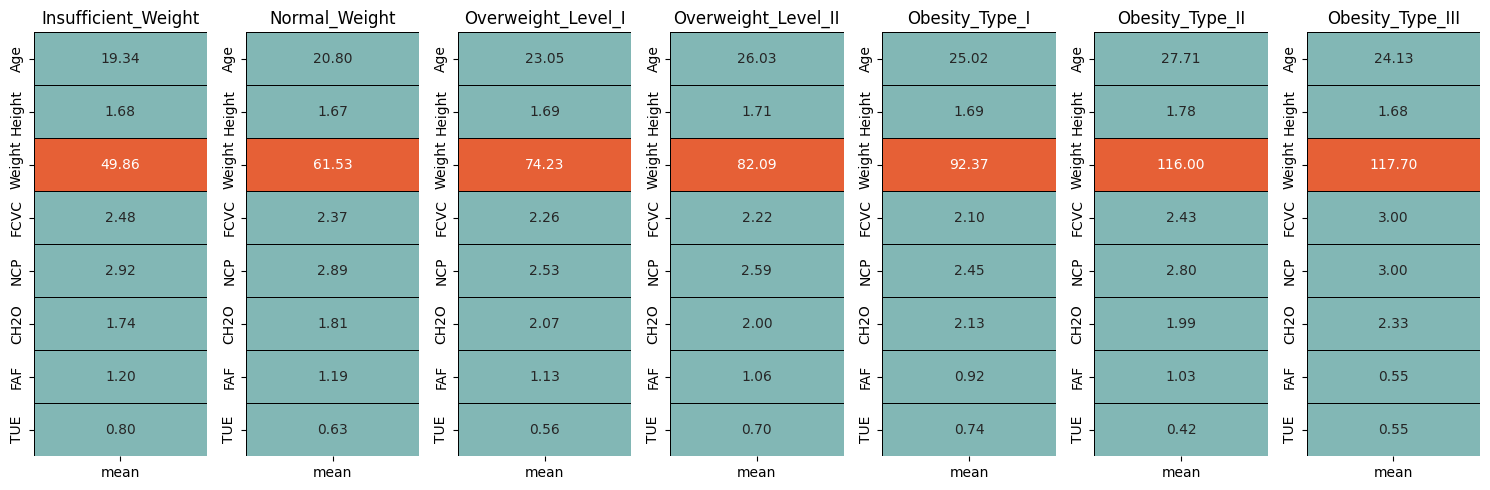

In [19]:
# mean của các feature có type float64 với các label
insufficient_weight = train[train['NObeyesdad'] == 'Insufficient_Weight'].describe().T
normal_weight = train[train['NObeyesdad'] == 'Normal_Weight'] .describe().T
overweight_1 = train[train['NObeyesdad'] == 'Overweight_Level_I'].describe().T
overweight_2 = train[train['NObeyesdad'] == 'Overweight_Level_II'].describe().T
obesity_1 = train[train['NObeyesdad'] == 'Obesity_Type_I'].describe().T
obesity_2 = train[train['NObeyesdad'] == 'Obesity_Type_II'].describe().T
obesity_3 = train[train['NObeyesdad'] == 'Obesity_Type_III'].describe().T

describe =  [insufficient_weight, normal_weight, overweight_1, overweight_2, obesity_1, obesity_2, obesity_3]
describe_label = ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II',
                  'Obesity_Type_I', 'Obesity_Type_II','Obesity_Type_III']
colors = ['#82B7B5' ,'#E66036']

fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(15,5))
for i in range(len(describe)):
   plt.subplot(1, 7, i+1)
   sns.heatmap(describe[i][['mean']], annot=True, cmap=colors, linewidth=0.4, linecolor='black', cbar=False, fmt='.2f')
   plt.title(describe_label[i])
fig.tight_layout()

* Từ visualization ở trên, tất cả class của NObeyesdad hiển thị giá trị mean của các feature khác
* Giá trị mean của weight feature tăng dần theo mức độ obesity
* Đối với Age, Height, TUE thì mean không có quy luật gì, dường như là ngẫu nhiên
* Đối với FCVC và NCP giảm dần từ trái sang phải nhưng đến Obesity_Type_II và Obesity_Type_III lại tăng lên
* Đối với CH2O và FAF từ trái sang phải tăng và giảm nhưng bị xáo trộn bởi Obesity_Type_II và Obesity_Type_I

## 2.Exploratory Data Analysis

### 2.1Target Distribution with Gender:

Text(0.5, 0.98, 'Target Value Anaysis')

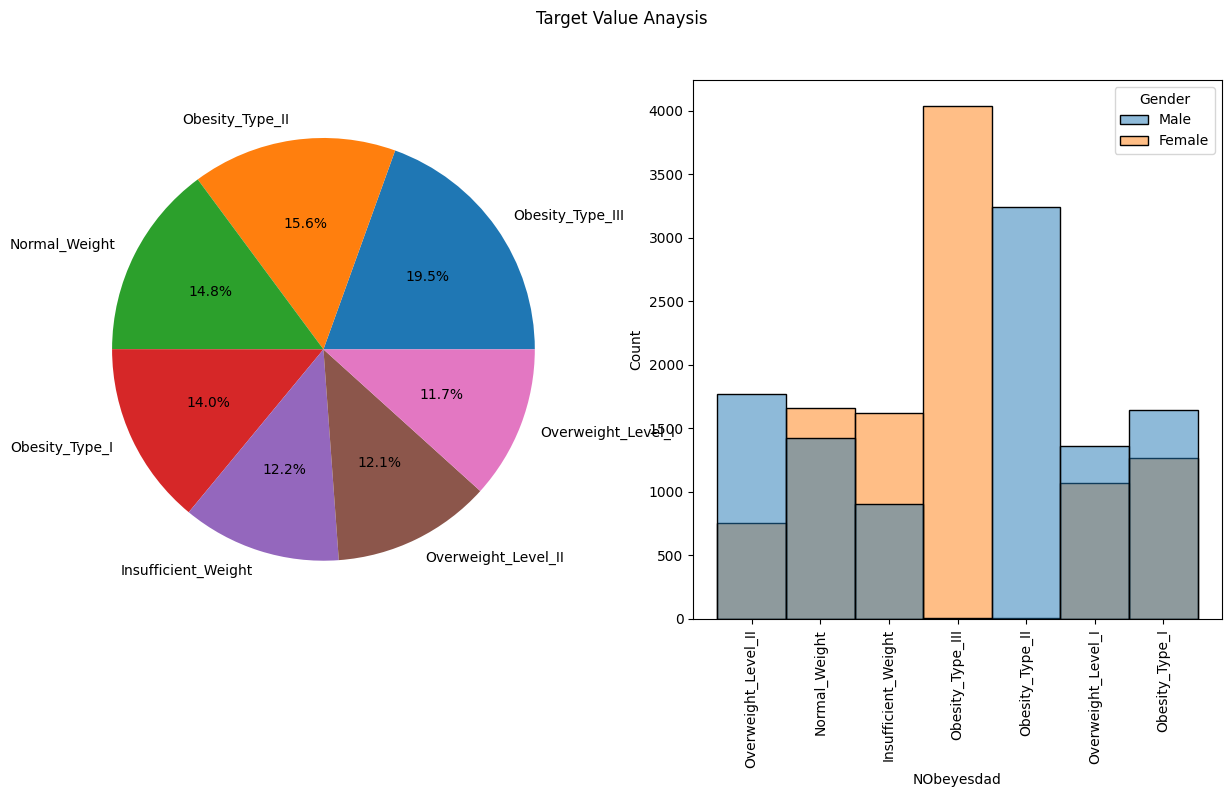

In [20]:
f, ax = plt.subplots(1,2, figsize=(15,7))
train['NObeyesdad'].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0])
ax[0].set_ylabel('')
sns.histplot(x='NObeyesdad', data=train, hue='Gender', ax=ax[1])
plt.xticks(rotation=90)
plt.suptitle('Target Value Anaysis')

* Class có phần trăm cao nhất **Obesity_Type_III** với **19.5%** và phần trăm thấp nhất là **Overweight_Level_I** với **11.7%**
* **Obesity_Type_II** cao thứ 2
* **Overweight_Level_II & Insufficient_Weight** có tỉ lệ gần ngang nhau
* **Obesity_Type_I & Normal_Weight** cũng có tỉ lệ gần ngang nhau
* Class **Obesity_Type_II** phổ biến ở **Male** và **Obesity_Type_III** phổ biến ở **Female**

### 2.2Categorical Variables Analysis:

In [21]:
categorical_vars = train.select_dtypes(include='object').columns.drop('NObeyesdad')
categorical_vars

Index(['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE',
       'SCC', 'CALC', 'MTRANS'],
      dtype='object')

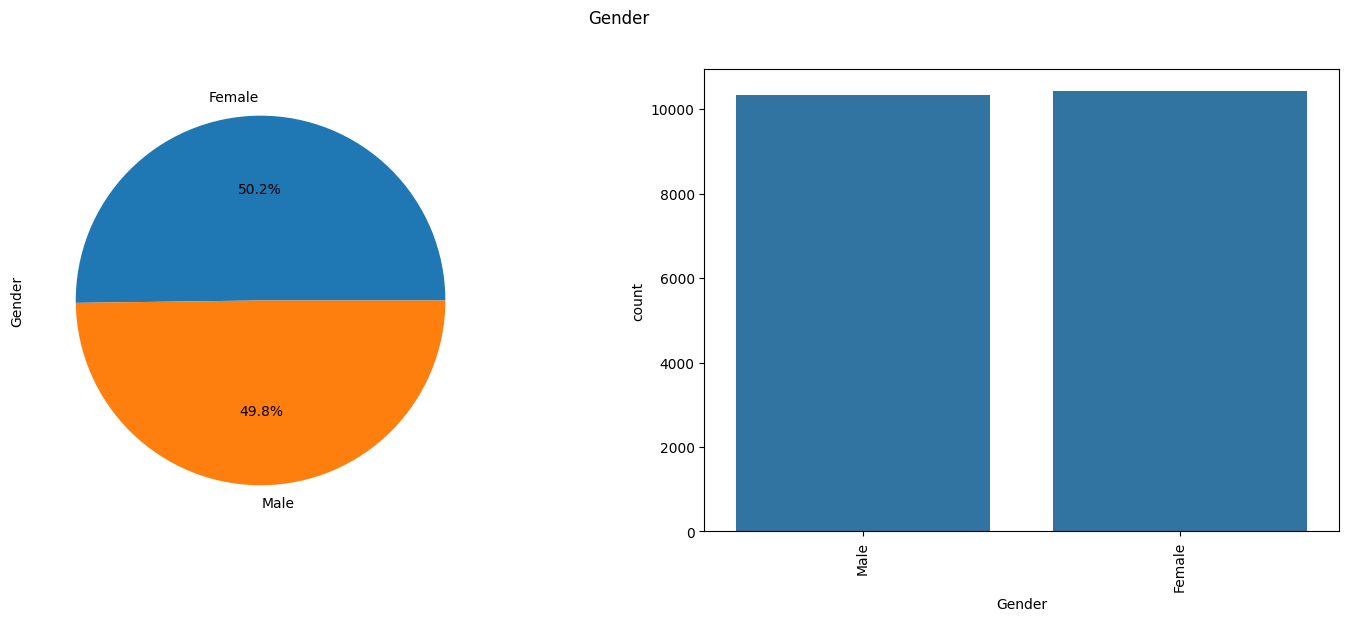

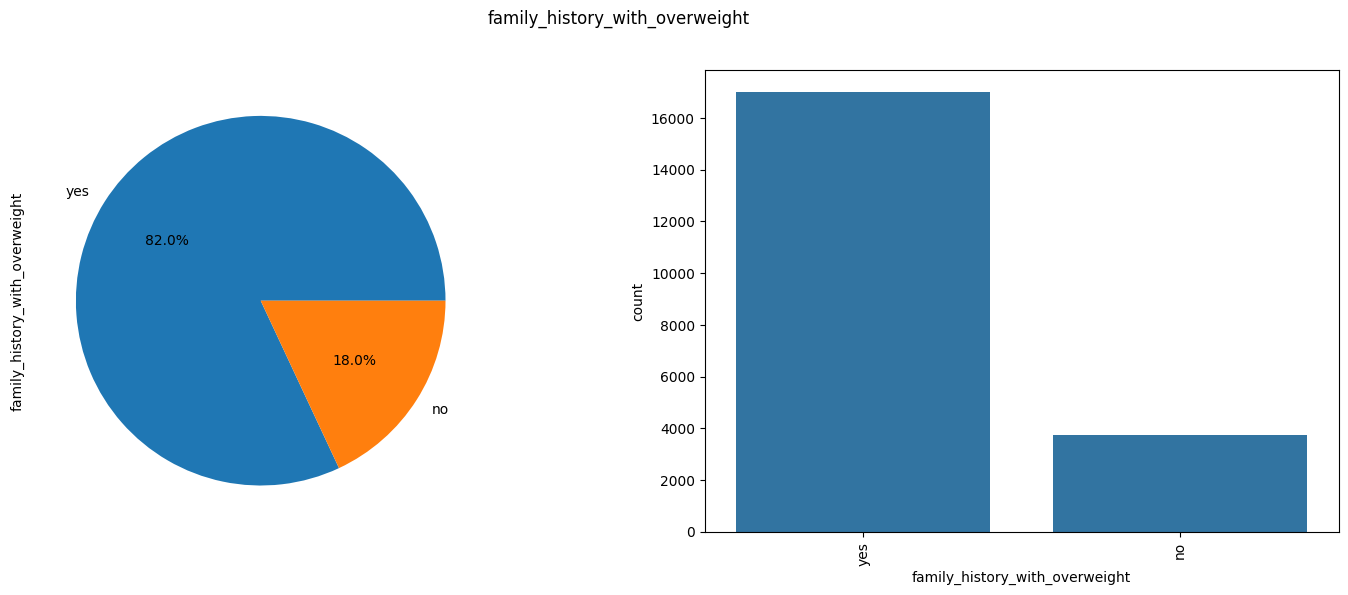

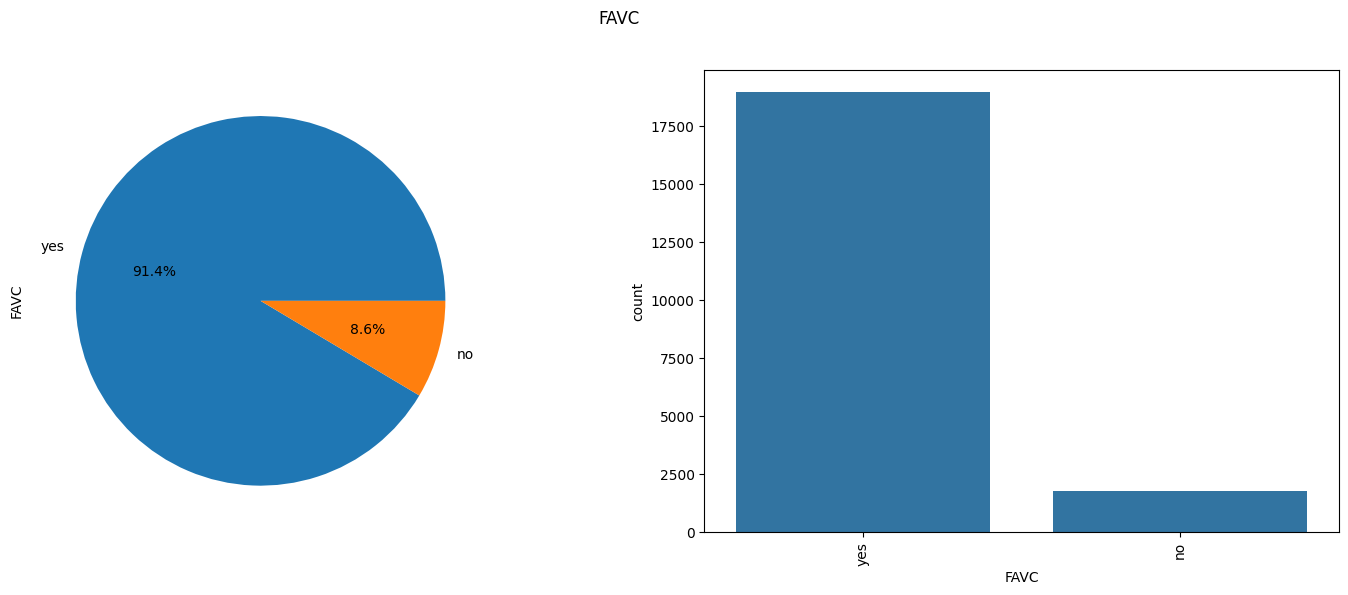

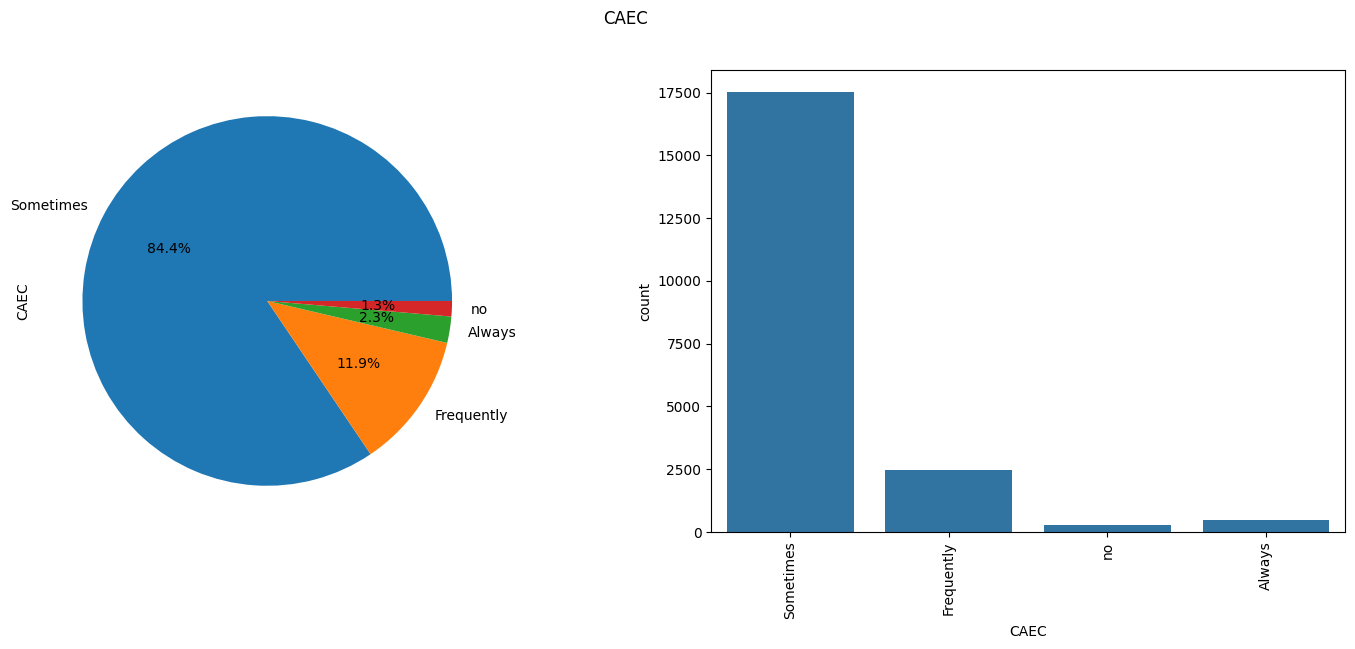

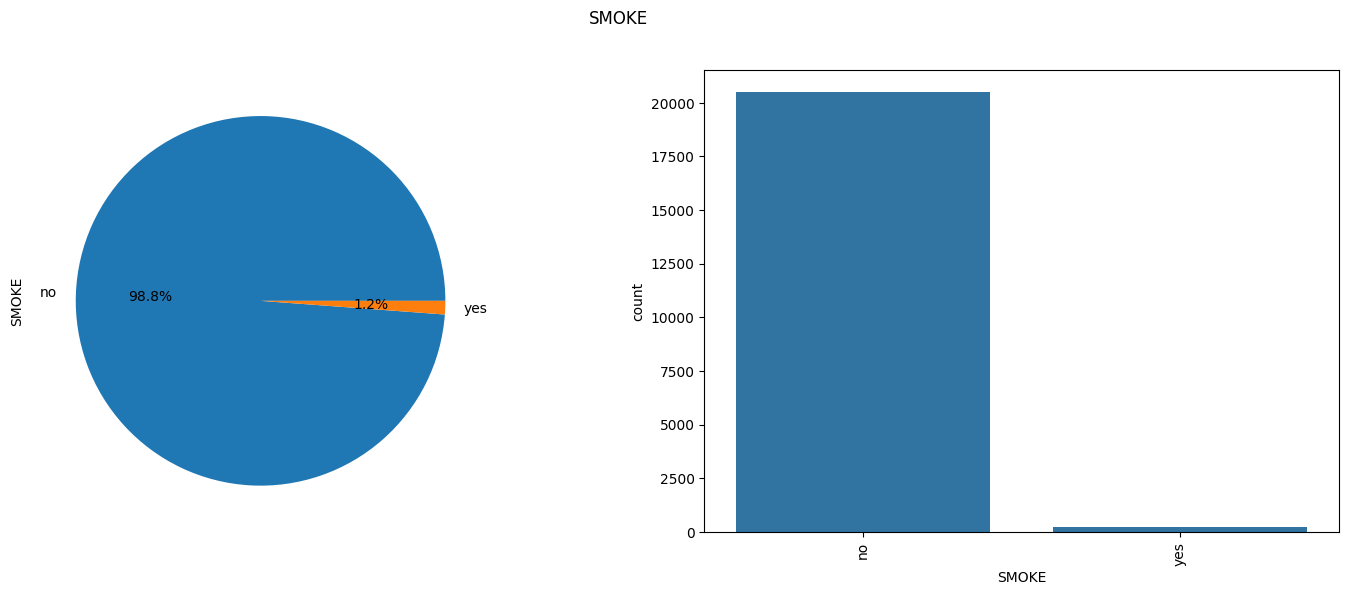

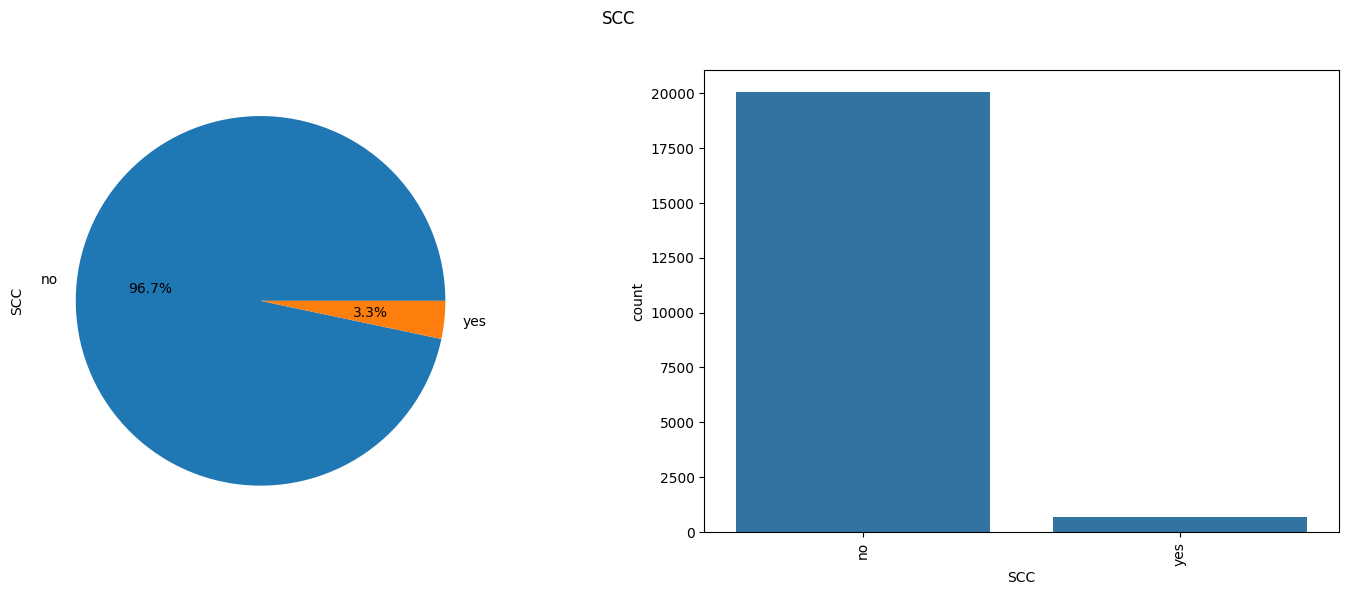

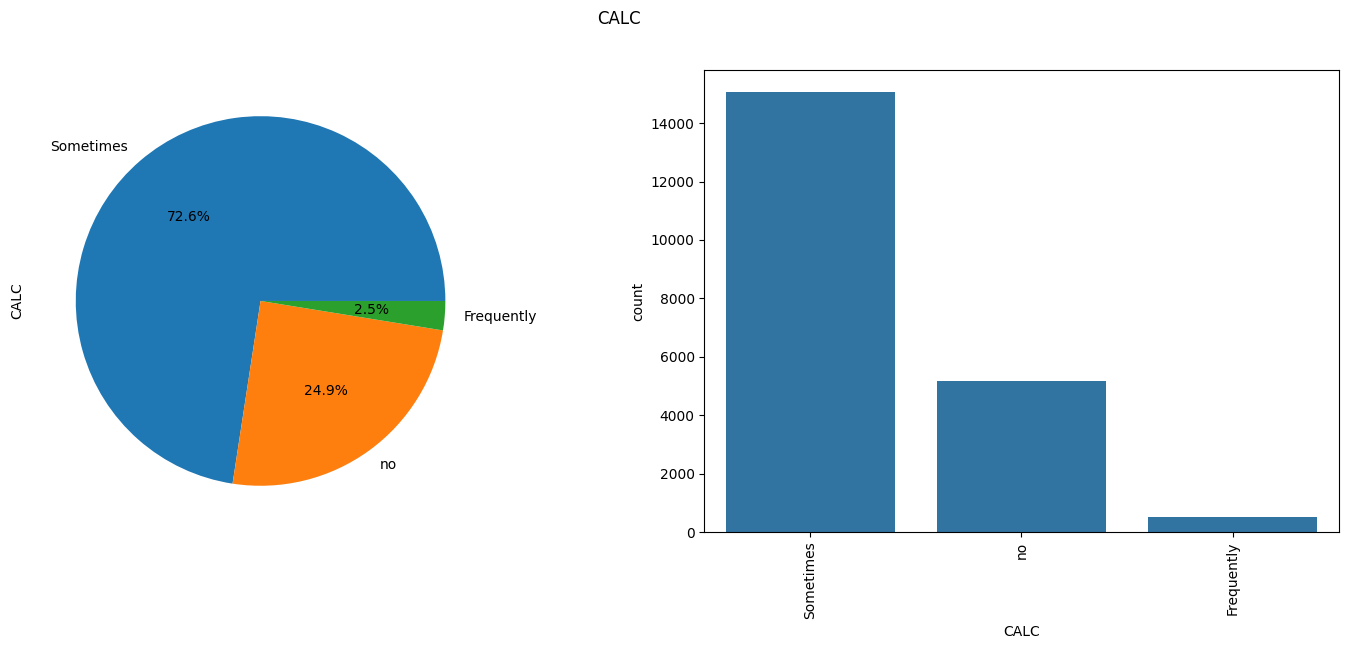

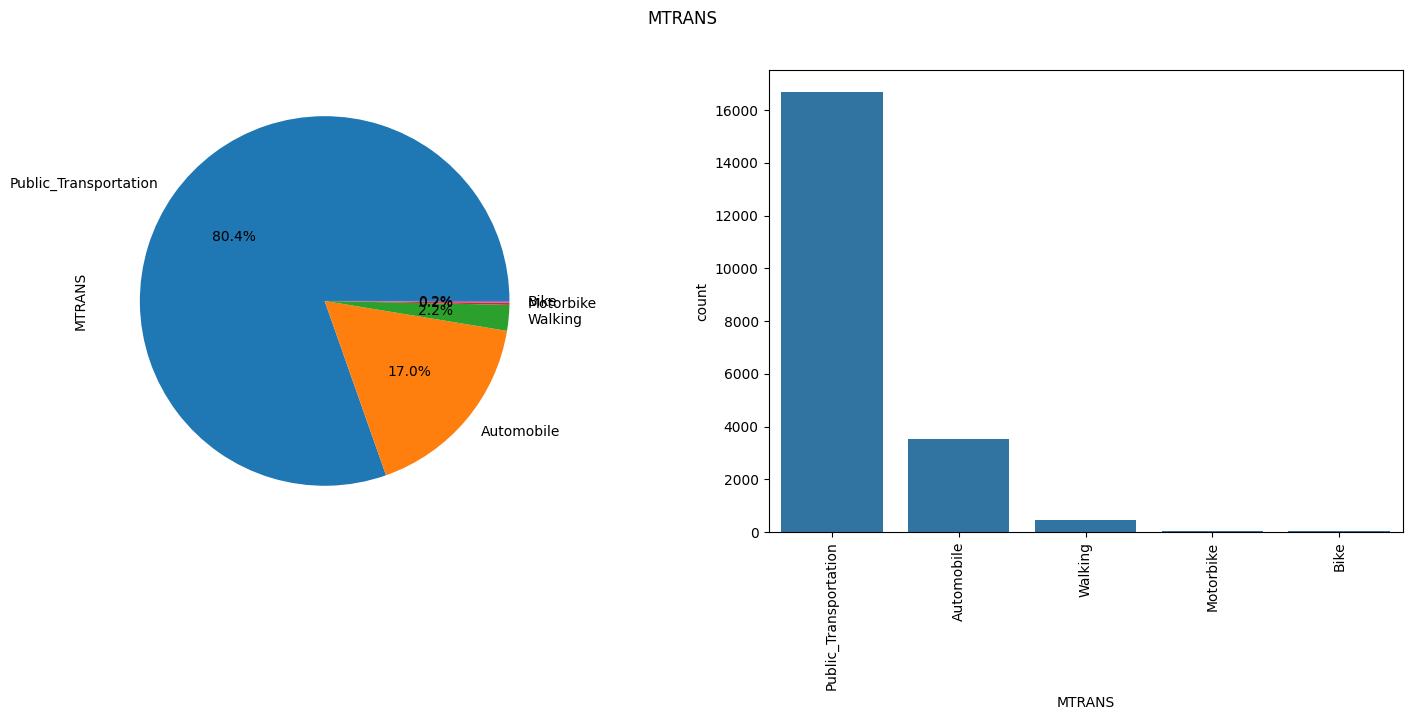

In [22]:
for column in categorical_vars :
    f, ax = plt.subplots(1,2, figsize=(18,6))
    train[column].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0])
    ax[0].set_ylabel(f'{column}')
    sns.countplot(x=column, data=train, ax=ax[1])
    plt.xticks(rotation=90)
    plt.suptitle(f'{column}')

* Feature **Age** phân phối cân bằng
* **82%** có **family_history_with_overweight**
* **91.4%** người **Frequently consume high caloric food**
* **84.4%** sometimes consumes food between meals và **1.3%** No meals in between
* **98.8%** người không hút thuốc
* **96.7%** người không giám sát tiêu thụ calo
* **72.6%** người thỉnh thoảng tiêu alcohol và **2.5%** người thì thường xuyên
* **97.6%** người sử dụng phương tiện, **~2.4%** đi bộ và xe đạp
* Nhiều feature như **family_history_with_overweight, FAVC, CAEC, SMOKE, SCC, CALC, MTRANS** bị mất cân bằng

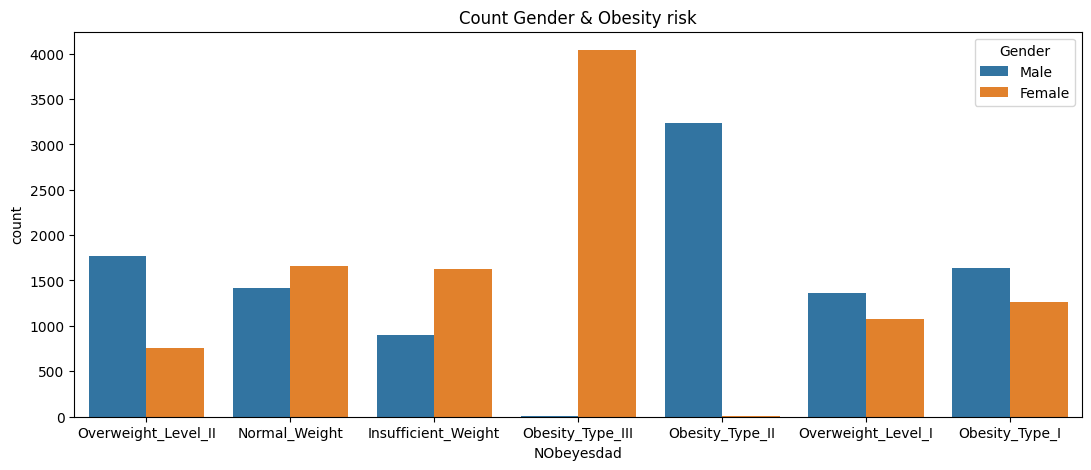

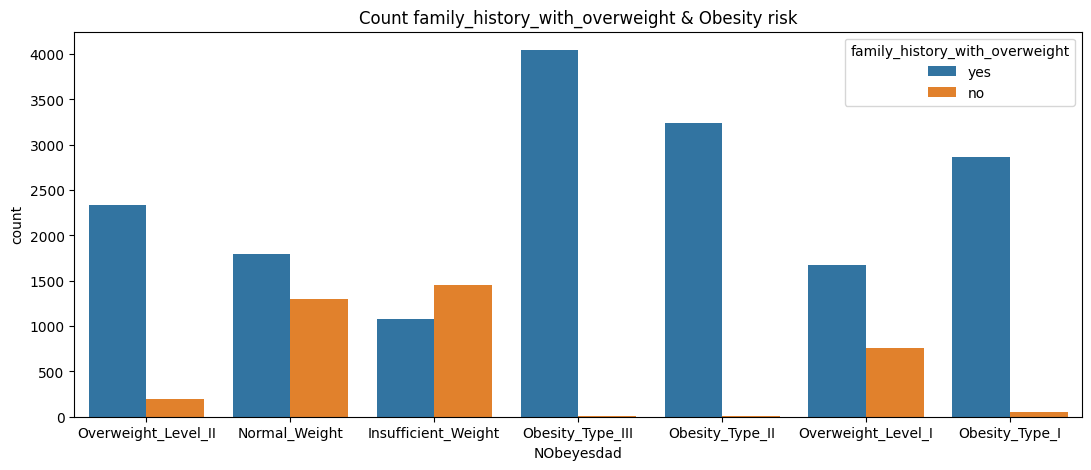

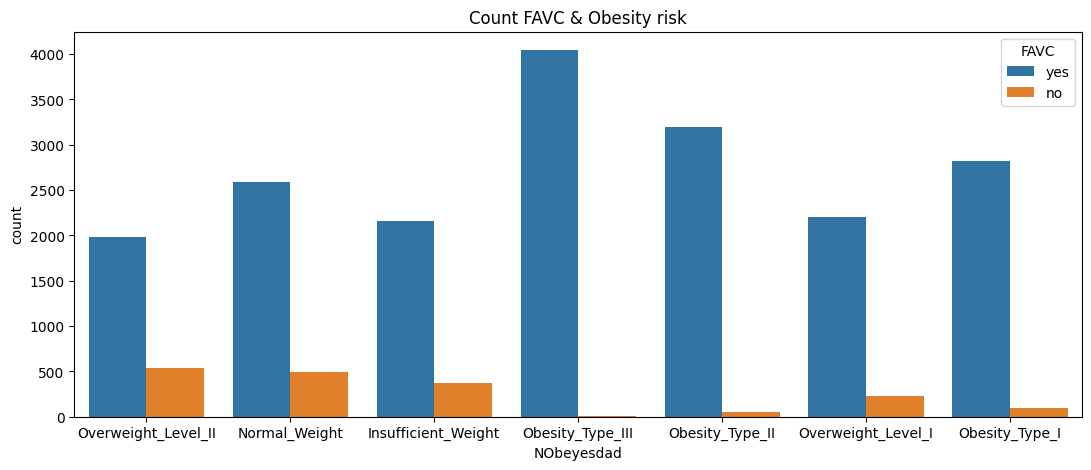

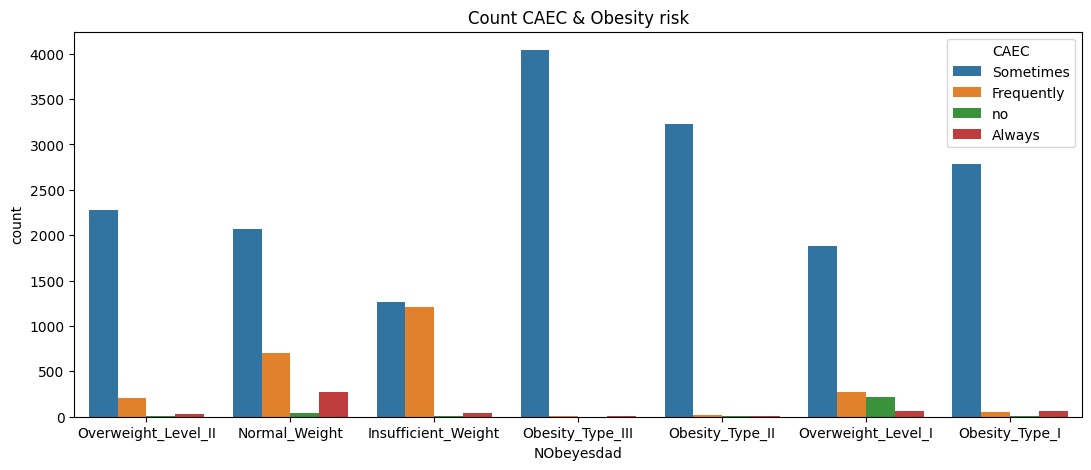

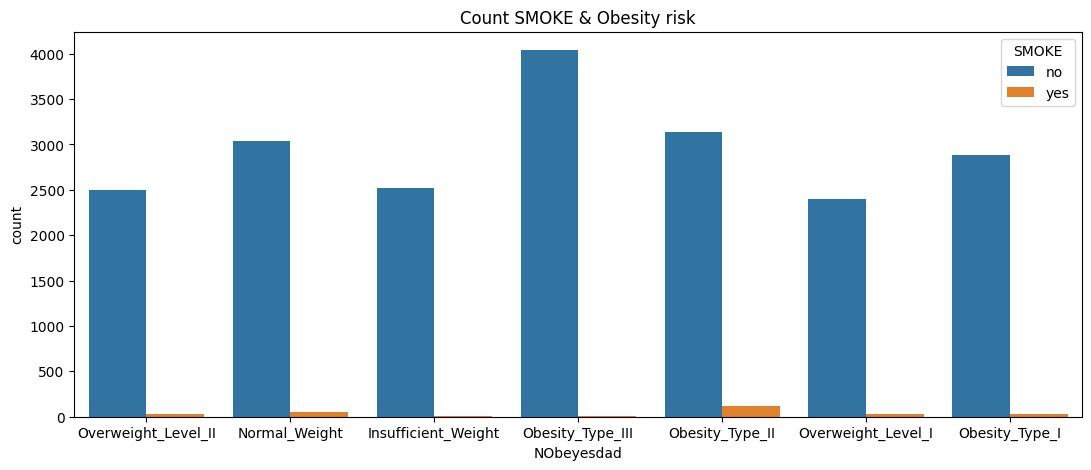

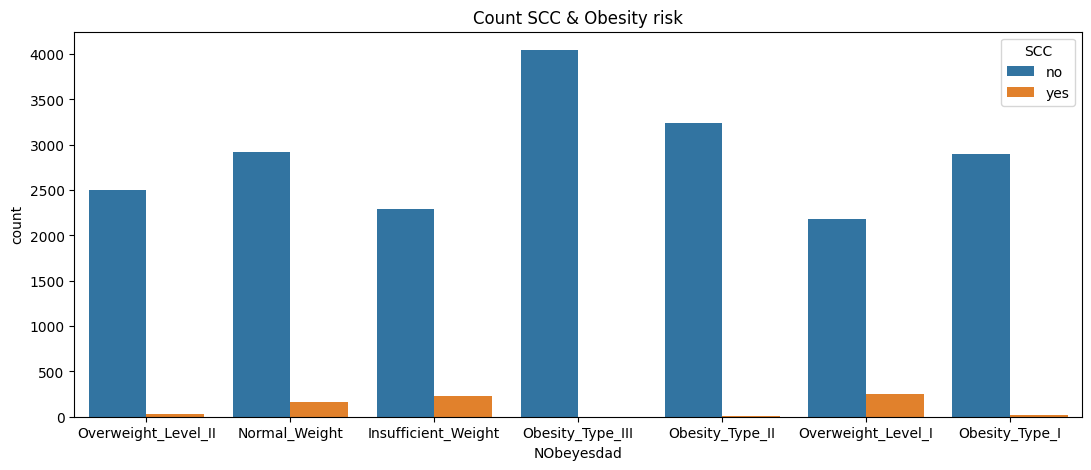

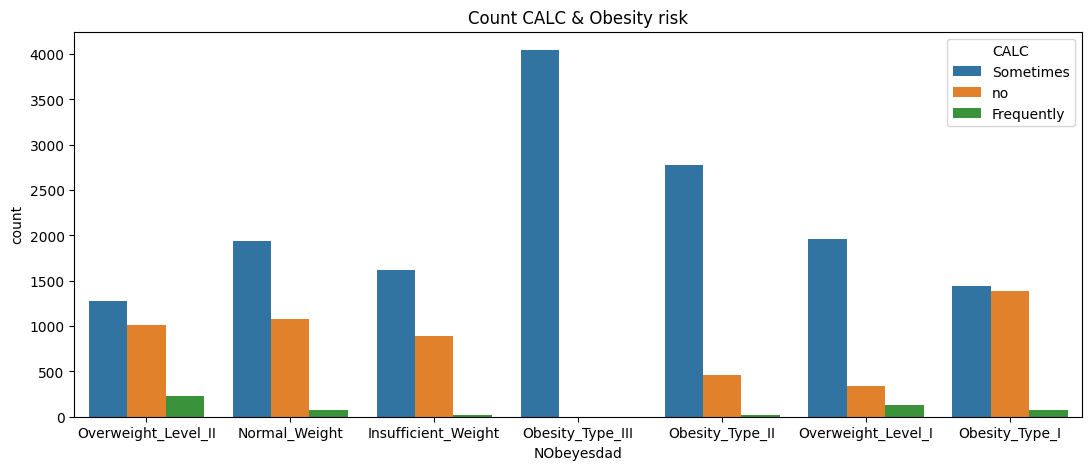

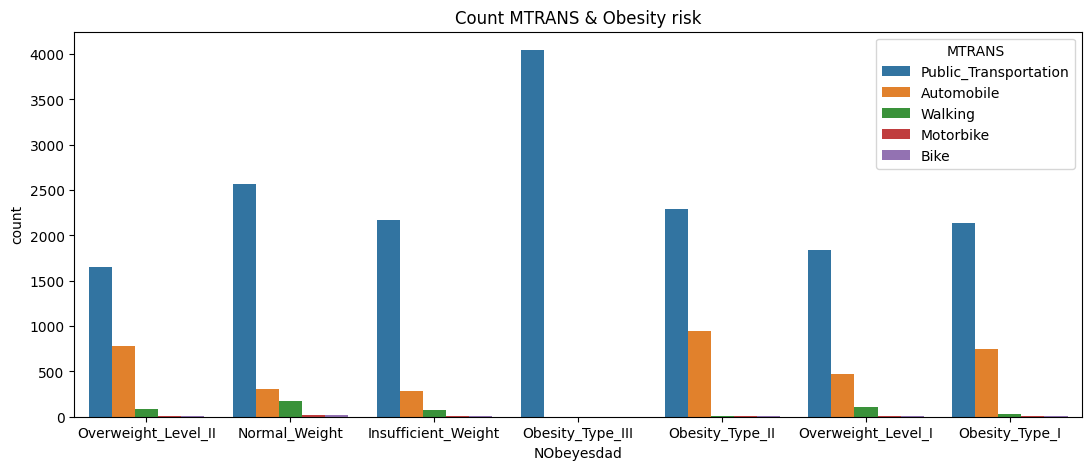

In [23]:
for i in categorical_vars:
    plt.figure(figsize=(13,5))
    plt.title(f"Count {i} & Obesity risk")
    sns.countplot(data=train, x='NObeyesdad', hue=i)



*   Class Obesity_Type_II chủ yếu là Male, class Obesity_Type_III chủ yếu là Female, các class còn lại thì tỉ lệ giữa Male và Female gần bằng nhau
*  feature family_history_with_overweight có chứa thông tin phân loại quan trọng, các class obesity thì đa số có label yes
*   FAVC, CAEC tương tự như family_history_with_overweight
*   SMOKE mất cân bằng nhiều, dường như feature này không giúp nhiều cho bài toán
*   Feature SCC cho biết class Obesity gần như không theo dõi mức tiêu thụ calo
*   các feature còn lại cũng mất cân bằng







### 2.3Numerical Value Analysis:

In [24]:
continuous_vars = train.select_dtypes(include='float').columns
continuous_vars

Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE'], dtype='object')

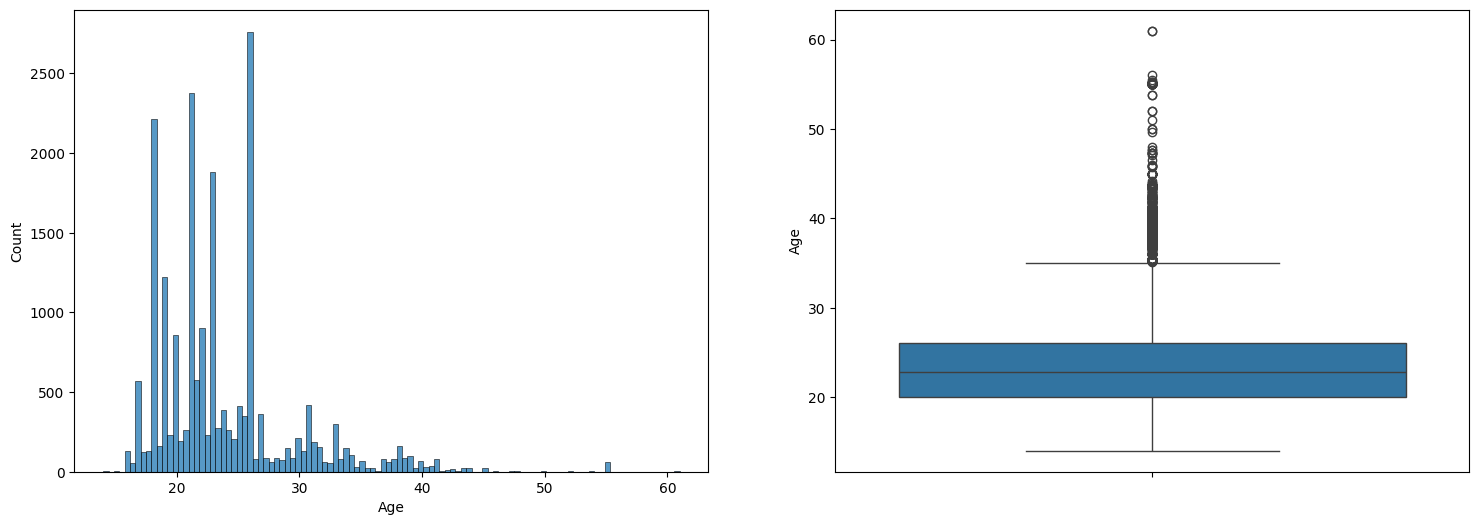

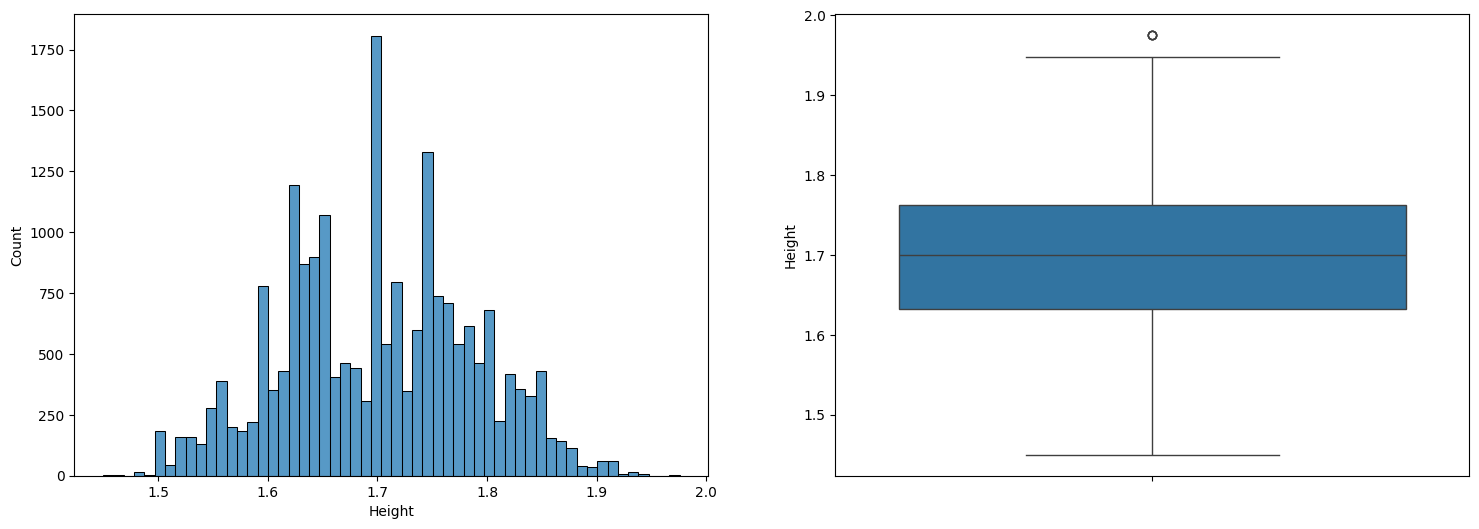

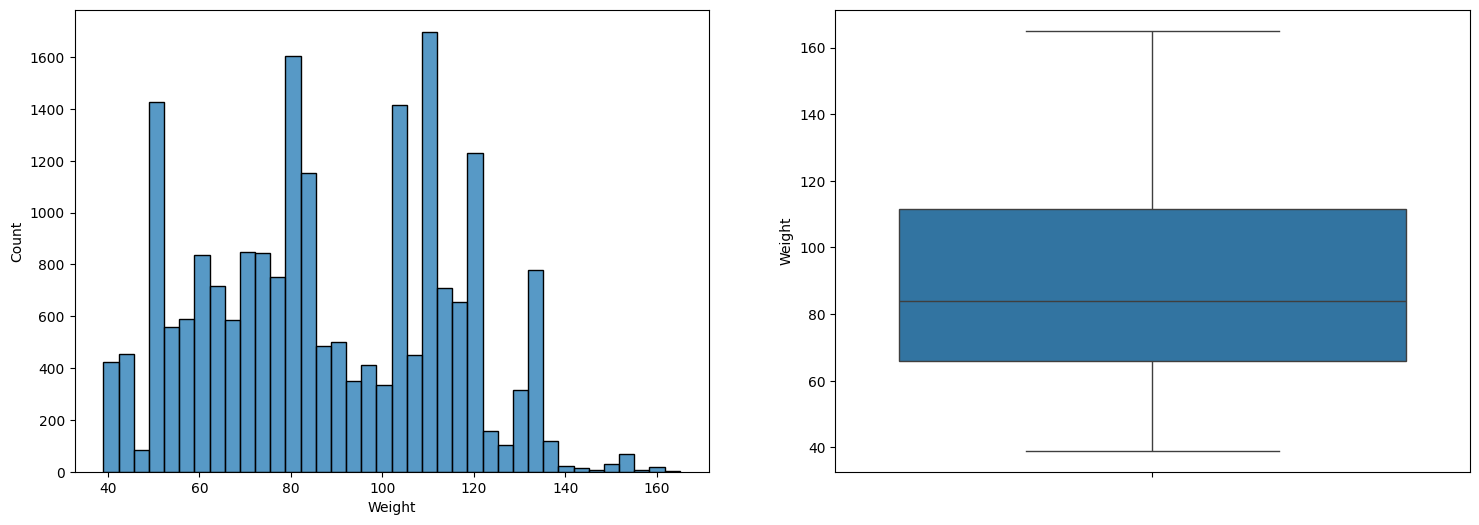

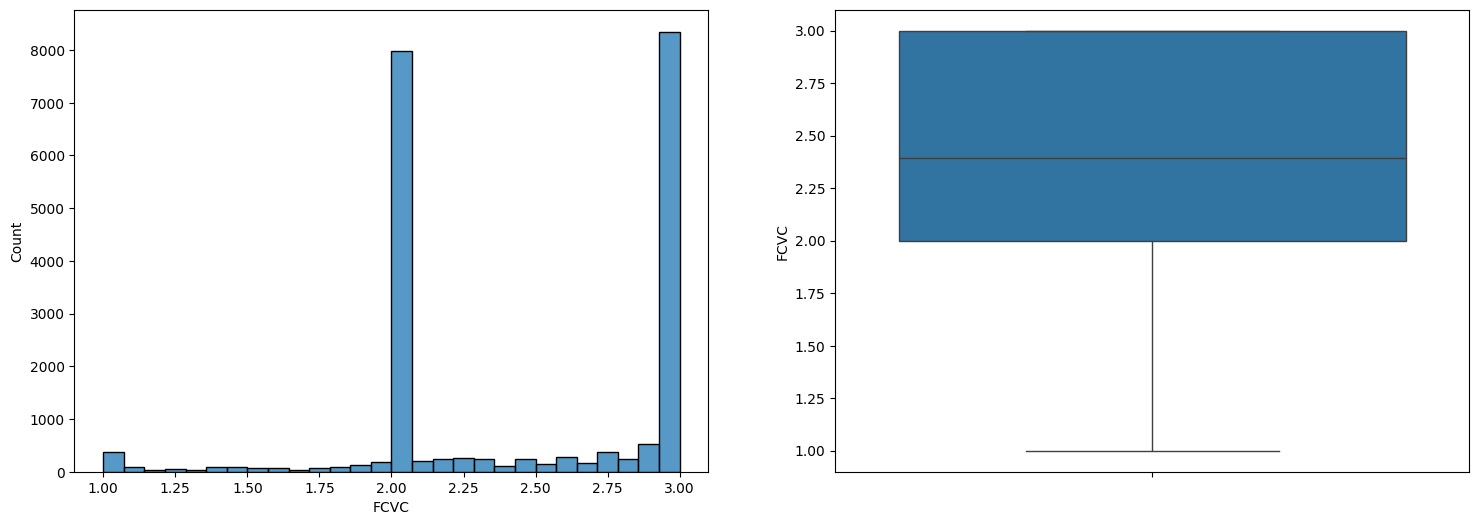

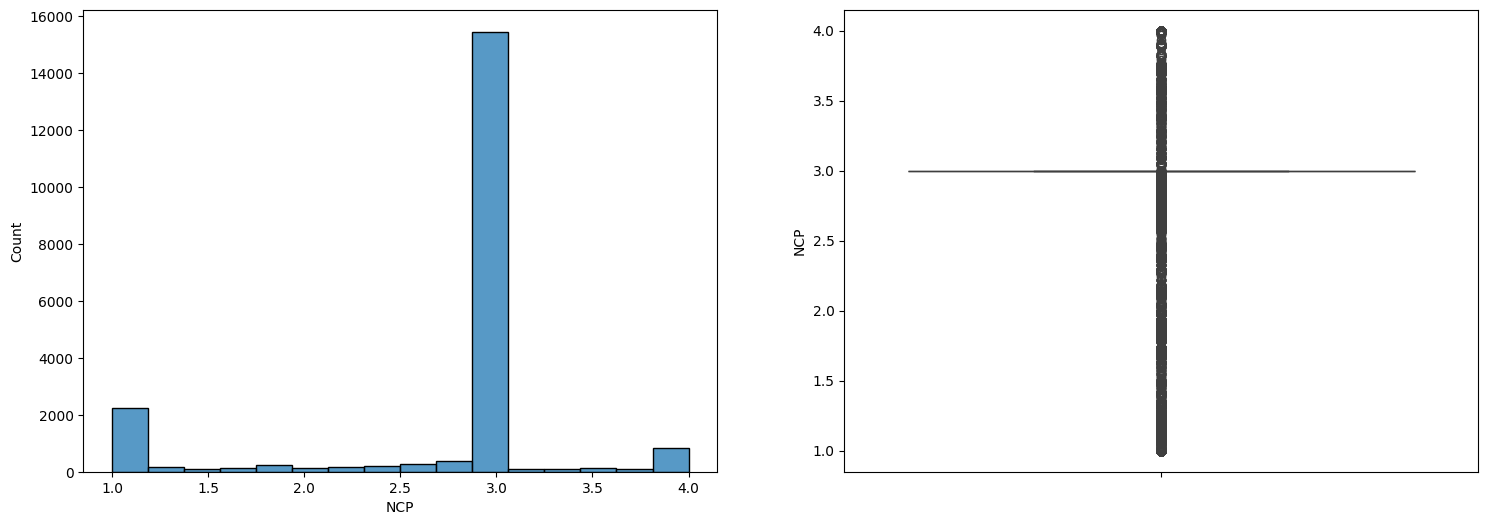

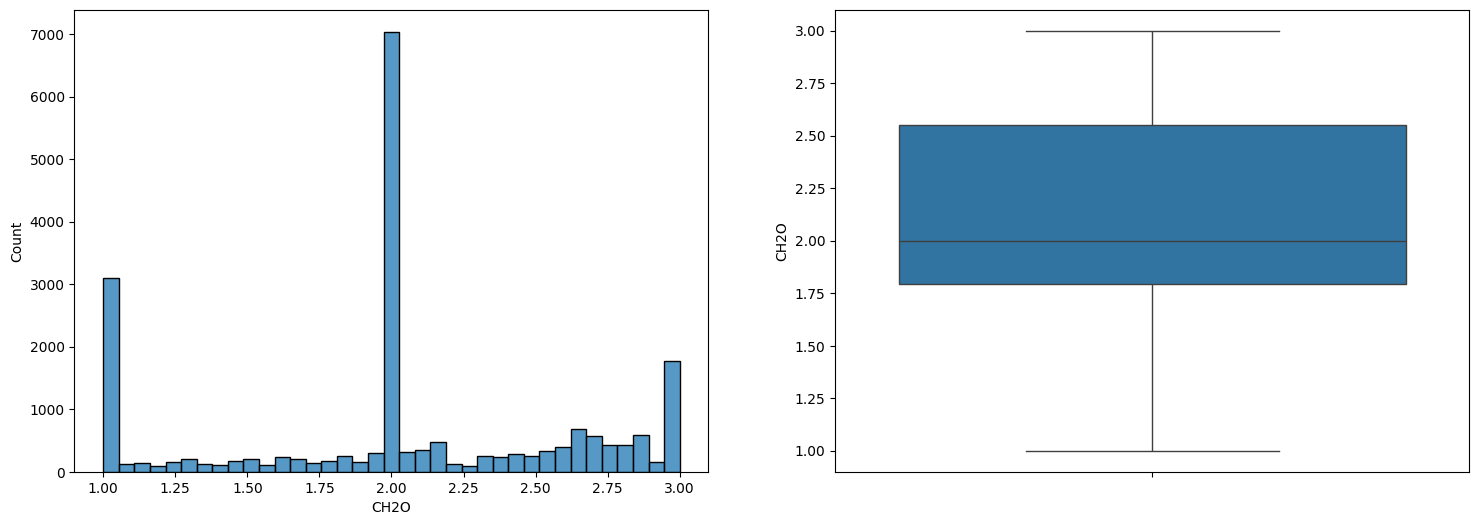

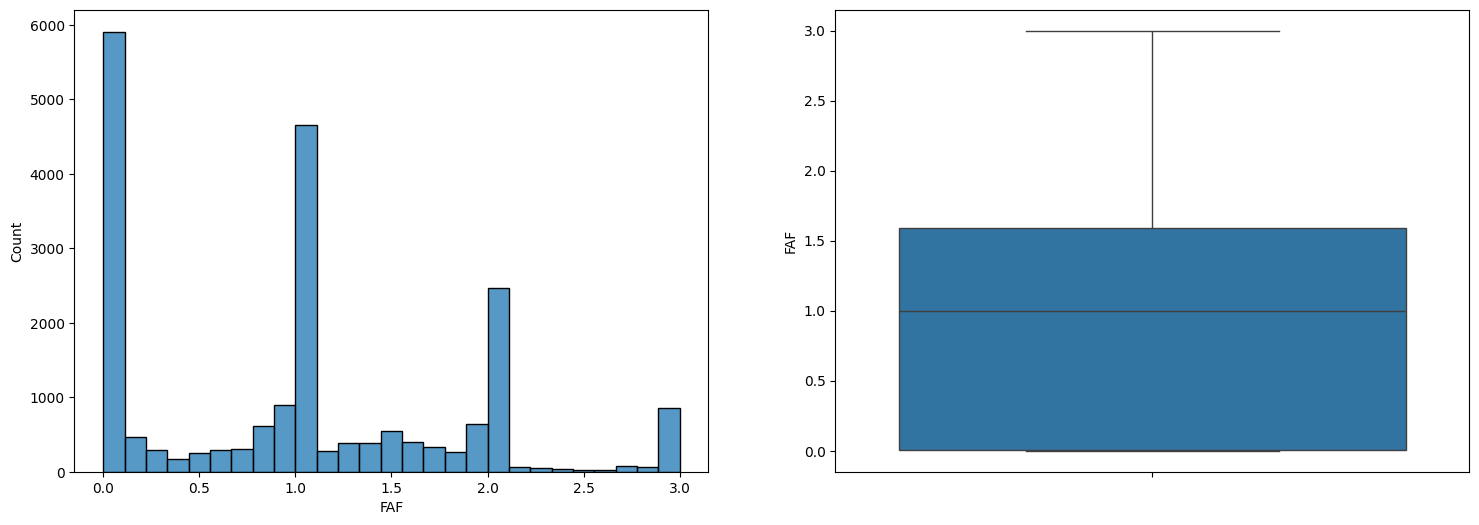

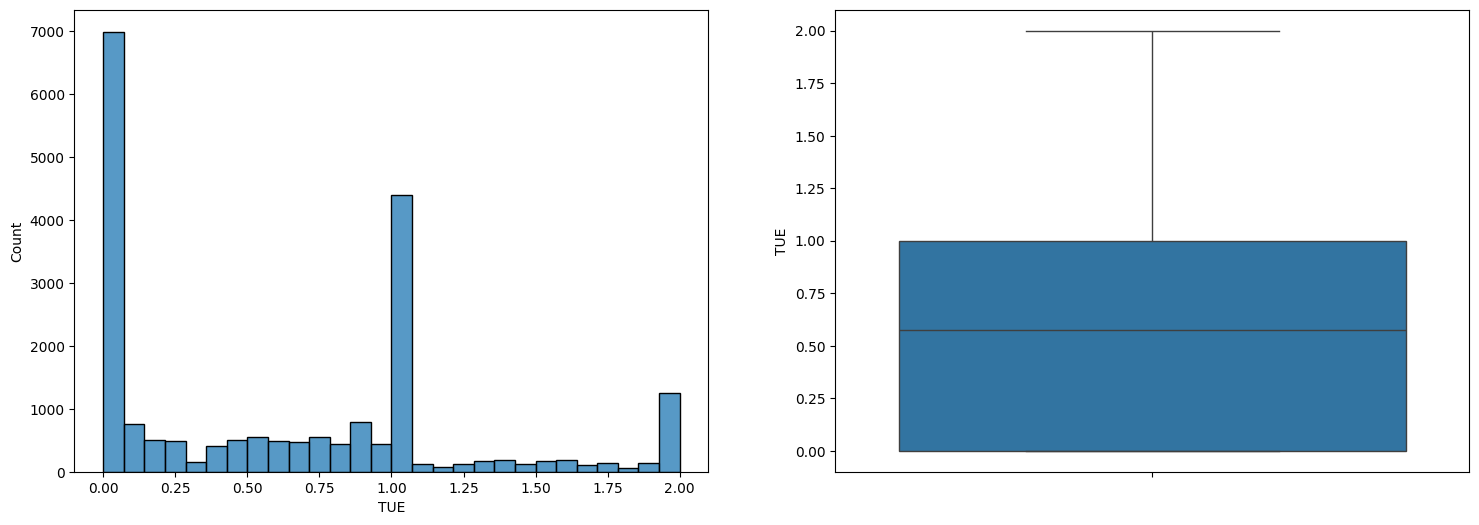

In [25]:
for column in continuous_vars:
    fig, ax =plt.subplots(1,2, figsize=(18,6))
    sns.histplot(data=train, x=column, ax=ax[0])
    sns.boxplot(train[column], ax=ax[1])

* Feature Age có nhiều outlier
* Các feature còn lại không có outlier
* Phần lớn các feature có đỉnh là 2-3 giá trị cụ thể

#### 2.4 Individual Numerical Plots

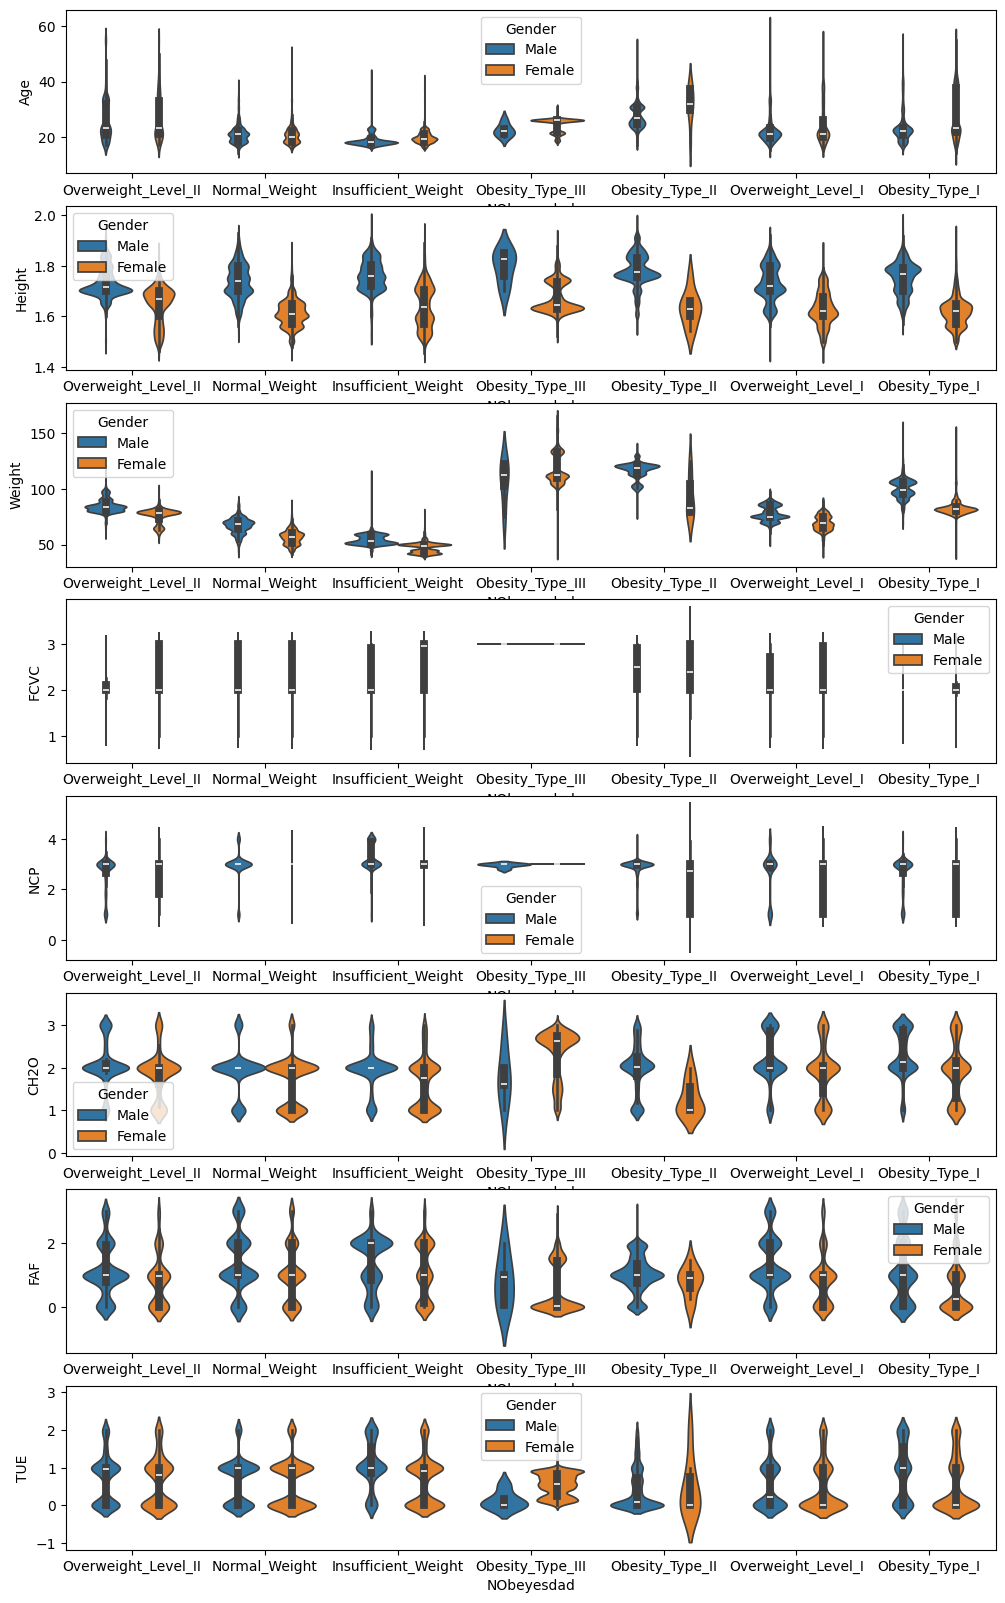

In [26]:
fig, ax = plt.subplots(len(continuous_vars), 1, figsize=(12, len(continuous_vars)*2.5))
for i, col in enumerate(continuous_vars):
  sns.violinplot(data=train, x = 'NObeyesdad', y=col,hue='Gender', ax=ax[i])
plt.tight_layout
plt.show()

#### Từ biểu đồ trên:
* **Insufficient_Weight và  Obesity_Type_III**  có Age thấp nhất từ 20-30, Các class khác có range của Age cao hơn **Overweight_Level_I**
* Không có nhiều khác biệt giá trị của **Height** trong các class
* **Weight** cho thấy sự khác biệt rõ rãng giữa các class
* Frequency of consumption of Vegetable là 3 đối với lớp Obesity_Type_III
* Những người thuộc Insufficient_Weight có Number of main meal cao hơn
* **CH2O, FAF** không có nhiều khác biệt trong các class
* Weight, Height và Gender là những feature quan trọng, Weight cho thấy sự khác biệt rõ rãng giữa các class

### 2.5 Ma trận tương quan

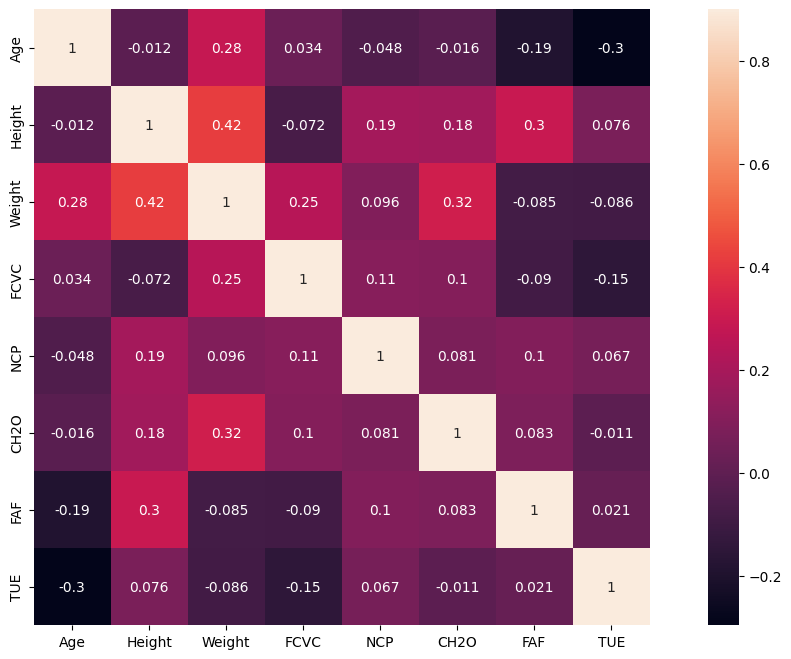

In [27]:
corr_train = train[continuous_vars].corr('pearson')
f, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(corr_train, vmax=0.9, square=True, annot=True)
plt.show()

* Height tương quan mạnh với Weight và FAF

### 2.6 Combined Numerical Plots

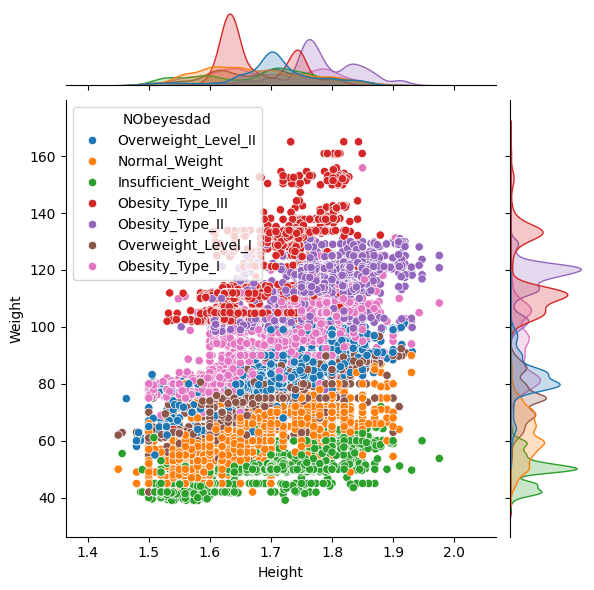

In [28]:
sns.jointplot(data=train, x='Height', y='Weight', hue='NObeyesdad')

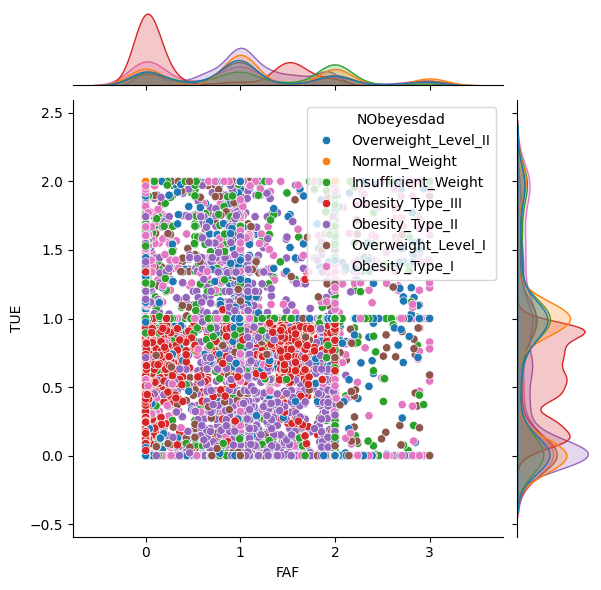

In [29]:
sns.jointplot(data=train, x='FAF', y='TUE', hue='NObeyesdad')

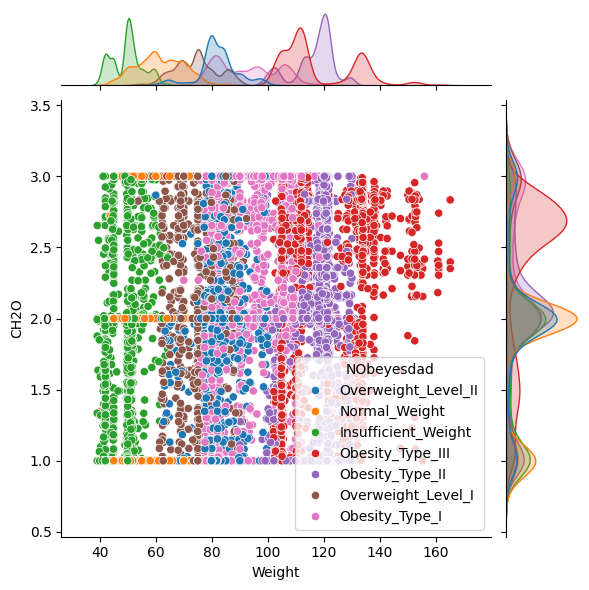

In [30]:
sns.jointplot(data=train, x='Weight', y='CH2O', hue='NObeyesdad')

Với mỗi điểm trên đồ thị Weight và Height phân loại rõ từng class, CH2O và Weight cũng tương tự

## 3.Feature Engineering & Processing

### 3.1 Encoder

In [31]:
# Xử lý label hiếm trong testset
test['CALC'] = test['CALC'].replace('Always', 'Frequently')
test['CALC'].value_counts()

CALC
Sometimes     9979
no            3513
Frequently     348
Name: count, dtype: int64

In [32]:
# chia trainset thành target và biến phụ thuộc
X, y = train.drop(['NObeyesdad'], axis=1), train['NObeyesdad']

In [33]:
# Mã hóa onehot
X = pd.get_dummies(X, drop_first=True, dtype=int)
test = pd.get_dummies(test, drop_first=True, dtype=int)
X.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Male,family_history_with_overweight_yes,...,CAEC_Sometimes,CAEC_no,SMOKE_yes,SCC_yes,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,24.443011,1.699998,81.669950,2.000000,2.983297,2.763573,0.000000,0.976473,1,1,...,1,0,0,0,1,0,0,0,1,0
1,18.000000,1.560000,57.000000,2.000000,3.000000,2.000000,1.000000,1.000000,0,1,...,0,0,0,0,0,1,0,0,0,0
2,18.000000,1.711460,50.165754,1.880534,1.411685,1.910378,0.866045,1.673584,0,1,...,1,0,0,0,0,1,0,0,1,0
3,20.952737,1.710730,131.274851,3.000000,3.000000,1.674061,1.467863,0.780199,0,1,...,1,0,0,0,1,0,0,0,1,0
4,31.641081,1.914186,93.798055,2.679664,1.971472,1.979848,1.967973,0.931721,1,1,...,1,0,0,0,1,0,0,0,1,0


In [34]:
# Encoder target classes
from sklearn.preprocessing import OrdinalEncoder
custom_mapping = {'Insufficient_Weight':0,
                  'Normal_Weight':1,
                  'Overweight_Level_I':2,
                  'Overweight_Level_II':3,
                  'Obesity_Type_I':4,
                  'Obesity_Type_II':5,
                  'Obesity_Type_III':6}
ordinal_encoder = OrdinalEncoder(categories=[[*custom_mapping.keys()]])
y = ordinal_encoder.fit_transform(y.values.reshape(-1,1))
y[:10]

array([[3.],
       [1.],
       [0.],
       [6.],
       [3.],
       [0.],
       [5.],
       [5.],
       [2.],
       [6.]])

### 3.2 Chọn Feature bằng chi2

In [35]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
selection_model =  SelectKBest(score_func=chi2, k=13)
selection_model.fit(X_train, y_train)
X_train_fs = selection_model.transform(X_train)
X_test_fs = selection_model.transform(X_val)

Feature Age: 4970.288406158784
Feature Height: 13.464497071653023
Feature Weight: 113451.383212793
Feature FCVC: 601.0163312446637
Feature NCP: 234.75747570892094
Feature CH2O: 300.97350992743384
Feature FAF: 928.6472728985556
Feature TUE: 421.90094147847464
Feature Gender_Male: 3188.2311467066465
Feature family_history_with_overweight_yes: 909.2469056645712
Feature FAVC_yes: 106.92440653397003
Feature CAEC_Frequently: 3317.086197959528
Feature CAEC_Sometimes: 586.7333406804513
Feature CAEC_no: 1009.4164994606319
Feature SMOKE_yes: 166.15593862632315
Feature SCC_yes: 772.1352492460126
Feature CALC_Sometimes: 766.6020547677334
Feature CALC_no: 1909.6046155136928
Feature MTRANS_Bike: 42.99115033569159
Feature MTRANS_Motorbike: 30.030200071826606
Feature MTRANS_Public_Transportation: 281.88274674502713
Feature MTRANS_Walking: 292.754965435234


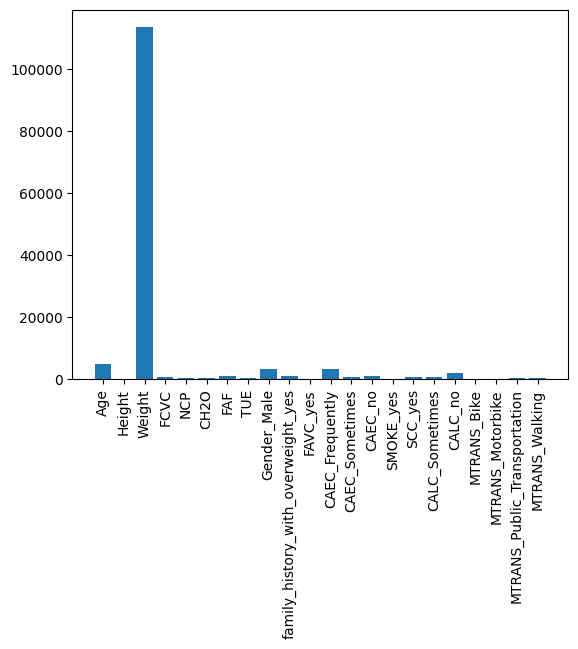

In [36]:
for i in range(len(selection_model.scores_)):
	print(f'Feature {X_train.columns[i]}: {selection_model.scores_[i]}')
# plot the scores
plt.bar([i for i in range(len(selection_model.scores_))], selection_model.scores_)
plt.xticks([i for i in range(len(selection_model.scores_))],X_train.columns , rotation=90)
plt.show()

In [37]:
# Các feature được chọn
selected_feat_chi2=X_train.columns[(selection_model.get_support())]
selected_feat_chi2

Index(['Age', 'Weight', 'FCVC', 'FAF', 'TUE', 'Gender_Male',
       'family_history_with_overweight_yes', 'CAEC_Frequently',
       'CAEC_Sometimes', 'CAEC_no', 'SCC_yes', 'CALC_Sometimes', 'CALC_no'],
      dtype='object')

### 3.3 Lựa chọn feature bằng phương pháp Random Forest

In [38]:
# chuẩn hoá dữ liệu
continuous_vars = X.select_dtypes(include='float').columns

def pre_stand(X,y,test, continuous_vars):
  # phân chia dataset
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
  X_test = test.copy()

  sc = StandardScaler()
  for num_col in continuous_vars:
      X_train[num_col] = sc.fit_transform(X_train[[num_col]])
      X_val[num_col] = sc.transform(X_val[[num_col]])
      X_test[num_col] = sc.transform(X_test[[num_col]])
  return X_train, X_val,y_train, y_val, X_test
X_train, X_val,y_train, y_val, X_test = pre_stand(X,y,test,continuous_vars)
X_train.head()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Male,family_history_with_overweight_yes,...,CAEC_Sometimes,CAEC_no,SMOKE_yes,SCC_yes,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
9958,-1.199372,0.800816,0.343527,1.044165,0.338791,-0.047425,2.394982,0.629728,1,1,...,0,0,0,0,0,1,0,0,0,0
7841,-0.213196,0.610243,-1.256602,-0.832617,1.759582,-0.047425,1.205953,0.629728,1,1,...,1,0,0,0,0,1,0,0,1,0
9293,-0.357492,1.372928,1.294154,1.044165,0.169457,-0.631484,-0.292365,-1.025610,1,1,...,1,0,0,0,1,0,0,0,1,0
15209,2.976687,-1.379006,-0.302254,-0.832617,0.338791,-1.694229,-1.172105,-1.025610,0,1,...,1,0,0,0,1,0,0,0,0,0
16515,-0.155357,1.144999,0.267553,1.044165,0.338791,1.599379,1.205953,0.629728,1,1,...,1,0,0,0,0,0,0,0,1,0


<Axes: >

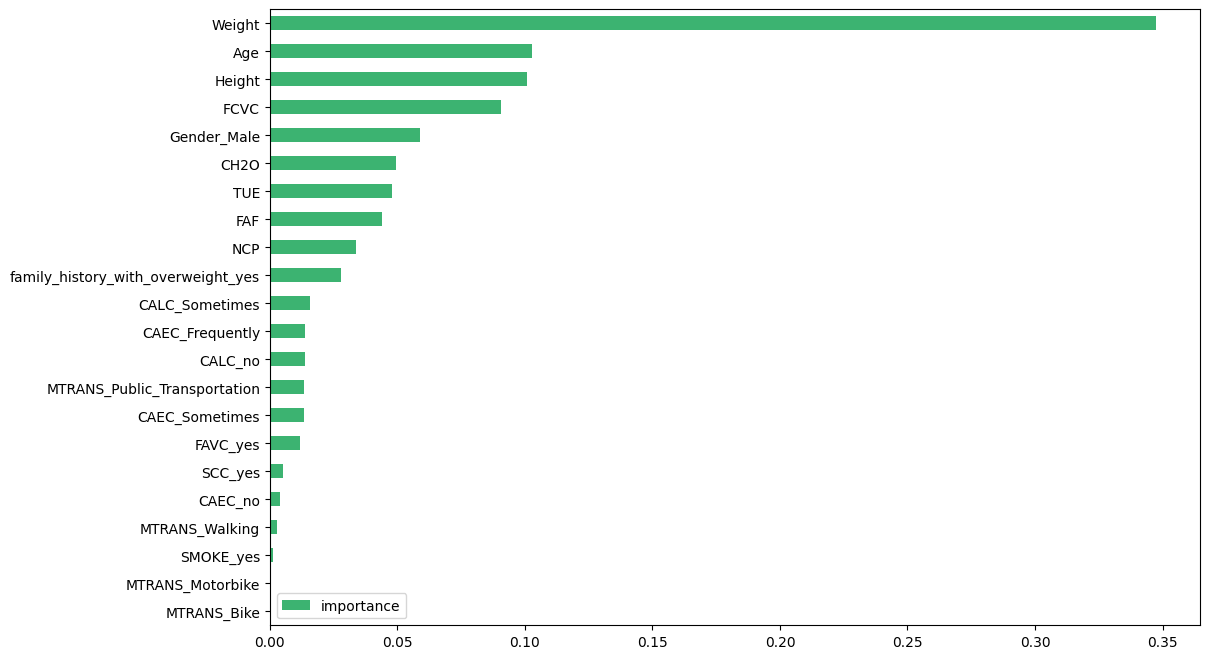

In [40]:
from sklearn.ensemble import RandomForestClassifier
best_rf = RandomForestClassifier(
    n_estimators=518,
    criterion='gini',
    min_samples_leaf=1,
    max_depth=73,
    min_samples_split=2,
    random_state=27,
)
best_rf.fit(X_train, y_train)
importance = best_rf.feature_importances_
feature_importance = pd.DataFrame(data=importance, index=X_train.columns, columns=['importance']) \
    .sort_values(ascending=True, by='importance')
feature_importance.plot(kind='barh', figsize=(12, 8), color='#3cb371')

In [41]:
# Loại bỏ 6 feature ít quan trọng nhất
selected_feat_rf = feature_importance[6:].index
print(selected_feat_rf)

Index(['FAVC_yes', 'CAEC_Sometimes', 'MTRANS_Public_Transportation', 'CALC_no',
       'CAEC_Frequently', 'CALC_Sometimes',
       'family_history_with_overweight_yes', 'NCP', 'FAF', 'TUE', 'CH2O',
       'Gender_Male', 'FCVC', 'Height', 'Age', 'Weight'],
      dtype='object')


## 4.Modeling

### 4.1 Train model

In [42]:
# Tạo function print accuracy
def print_result(model, X_train,X_test, y_train, y_test, selected_feat_chi2, selected_feat_rf):
    # Sử dụng tất cả feature
    model.fit(X_train, y_train)

    print(model)
    print()
    print('All feature')
    print('='*40)

    print('Train')
    y_pred=model.predict(X_train)
    print('accuracy:', accuracy_score(y_train, y_pred))
    print()
    print('Validation')
    y_pred=model.predict(X_test)
    accuracy_all =  accuracy_score(y_test, y_pred)
    print('accuracy:',accuracy_all)
    print('='*40)

    # Sử dụng các feature lựa chọn bằng chi2
    model.fit(X_train[selected_feat_chi2], y_train)

    print()
    print('Chi2 selected fearures')
    print('='*40)

    print('Train')
    y_pred=model.predict(X_train[selected_feat_chi2])
    print('accuracy:', accuracy_score(y_train, y_pred))
    print()
    print('Validation')
    y_pred=model.predict(X_test[selected_feat_chi2])
    accuracy_chi2 = accuracy_score(y_test, y_pred)
    print('accuracy:', accuracy_chi2)
    print('='*40)

    # Sử dụng các feature lựa chọn bằng RandomForest
    model.fit(X_train[selected_feat_rf], y_train)

    print()
    print('RandomForest selected fearures')
    print('='*40)

    print('Train')
    y_pred=model.predict(X_train[selected_feat_rf])
    print('accuracy:', accuracy_score(y_train, y_pred))
    print()
    print('Validation')
    y_pred=model.predict(X_test[selected_feat_rf])
    accuracy_rf = accuracy_score(y_test, y_pred)
    print('accuracy:', accuracy_rf)
    print('='*40)
    return round(accuracy_all, 4),round(accuracy_chi2, 4) , round(accuracy_rf, 4)

Training 1 số model

In [45]:
# tạo dict chứa các accuracy
dict_accuracy = {
    'LogisticRegression':[],
    'DecisionTreeClassifier':[],
    'AdaBoostClassifier':[],
    'RandomForestClassifier':[],
    'LGBMClassifier':[],
    'GradientBoostingClassifier':[],
    'XGBClassifier':[],
    'SVC':[]
}

In [46]:
model=LogisticRegression()
accuracy_all, accuracy_chi2, accuracy_rf=print_result(model, X_train, X_val, y_train, y_val, selected_feat_chi2, selected_feat_rf)
dict_accuracy['LogisticRegression'] += [accuracy_all, accuracy_chi2, accuracy_rf]

LogisticRegression()

All feature
Train
accuracy: 0.863784174394797

Validation
accuracy: 0.8672928709055877

Chi2 selected fearures
Train
accuracy: 0.8008551126099

Validation
accuracy: 0.8058766859344894

RandomForest selected fearures
Train
accuracy: 0.8625195712393111

Validation
accuracy: 0.8622350674373795


In [ ]:
model = tree.DecisionTreeClassifier()
accuracy_all, accuracy_chi2, accuracy_rf=print_result(model, X_train, X_val, y_train, y_val, selected_feat_chi2, selected_feat_rf)
dict_accuracy['DecisionTreeClassifier'] += [accuracy_all, accuracy_chi2, accuracy_rf]

DecisionTreeClassifier()

All feature
Train
accuracy: 1.0

Validation
accuracy: 0.8473025048169557

Chi2 selected fearures
Train
accuracy: 0.9891605443815489

Validation
accuracy: 0.8133429672447013

RandomForest selected fearures
Train
accuracy: 0.9999397808021198

Validation
accuracy: 0.8422447013487476


In [ ]:
model = AdaBoostClassifier()
accuracy_all, accuracy_chi2, accuracy_rf=print_result(model, X_train, X_val, y_train, y_val, selected_feat_chi2, selected_feat_rf)
dict_accuracy['AdaBoostClassifier'] += [accuracy_all, accuracy_chi2, accuracy_rf]

AdaBoostClassifier()

All feature
Train
accuracy: 0.42123328917258823

Validation
accuracy: 0.4328034682080925

Chi2 selected fearures
Train
accuracy: 0.522883295194508

Validation
accuracy: 0.526252408477842

RandomForest selected fearures
Train
accuracy: 0.42123328917258823

Validation
accuracy: 0.4328034682080925


In [ ]:
model = RandomForestClassifier()
accuracy_all, accuracy_chi2, accuracy_rf=print_result(model, X_train, X_val, y_train, y_val, selected_feat_chi2, selected_feat_rf)
dict_accuracy['RandomForestClassifier'] += [accuracy_all, accuracy_chi2, accuracy_rf]

RandomForestClassifier()

All feature
Train
accuracy: 1.0

Validation
accuracy: 0.8884874759152216

Chi2 selected fearures
Train
accuracy: 0.9891605443815489

Validation
accuracy: 0.8485067437379576

RandomForest selected fearures
Train
accuracy: 0.9998795616042394

Validation
accuracy: 0.8928227360308285


In [ ]:
model = LGBMClassifier()
accuracy_all, accuracy_chi2, accuracy_rf=print_result(model, X_train, X_val, y_train, y_val, selected_feat_chi2, selected_feat_rf)
dict_accuracy['LGBMClassifier'] += [accuracy_all, accuracy_chi2, accuracy_rf]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005613 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2025
[LightGBM] [Info] Number of data points in the train set: 16606, number of used features: 22
[LightGBM] [Info] Start training from score -2.117117
[LightGBM] [Info] Start training from score -1.911230
[LightGBM] [Info] Start training from score -2.145531
[LightGBM] [Info] Start training from score -2.112625
[LightGBM] [Info] Start training from score -1.948141
[LightGBM] [Info] Start training from score -1.857720
[LightGBM] [Info] Start training from score -1.633574
LGBMClassifier()

All feature
Train
accuracy: 0.9812718294592316

Validation
accuracy: 0.9058285163776493
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002047 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[

In [ ]:
model = GradientBoostingClassifier()
accuracy_all, accuracy_chi2, accuracy_rf=print_result(model, X_train, X_val, y_train, y_val, selected_feat_chi2, selected_feat_rf)
dict_accuracy['GradientBoostingClassifier'] += [accuracy_all, accuracy_chi2, accuracy_rf]

GradientBoostingClassifier()

All feature
Train
accuracy: 0.921835481151391

Validation
accuracy: 0.904383429672447

Chi2 selected fearures
Train
accuracy: 0.8858846200168614

Validation
accuracy: 0.8721098265895953

RandomForest selected fearures
Train
accuracy: 0.9223774539323136

Validation
accuracy: 0.904383429672447


In [ ]:
model = XGBClassifier()
accuracy_all, accuracy_chi2, accuracy_rf=print_result(model, X_train, X_val, y_train, y_val, selected_feat_chi2, selected_feat_rf)
dict_accuracy['XGBClassifier'] += [accuracy_all, accuracy_chi2, accuracy_rf]

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

All feature
Train
accuracy: 0.9873539684451403

Validation
accuracy: 0.9002890173410405

Chi2 selected fearures
Train
accuracy: 0.9509815729254486

Validation
accuracy: 0.8672928709055877

RandomForest selected fearures
Train
accura

In [ ]:
model=SVC()
accuracy_all, accuracy_chi2, accuracy_rf=print_result(model, X_train, X_val, y_train, y_val, selected_feat_chi2, selected_feat_rf)
dict_accuracy['SVC'] += [accuracy_all, accuracy_chi2, accuracy_rf]

SVC()

All feature
Train
accuracy: 0.8981693363844394

Validation
accuracy: 0.8778901734104047

Chi2 selected fearures
Train
accuracy: 0.8428881127303385

Validation
accuracy: 0.8268304431599229

RandomForest selected fearures
Train
accuracy: 0.8960014452607491

Validation
accuracy: 0.875


In [ ]:
dict_accuracy

{'LogisticRegression': [0.8673, 0.8059, 0.8622],
 'DecisionTreeClassifier': [0.8473, 0.8133, 0.8422],
 'AdaBoostClassifier': [0.4328, 0.5263, 0.4328],
 'RandomForestClassifier': [0.8885, 0.8485, 0.8928],
 'LGBMClassifier': [0.9058, 0.8752, 0.9025],
 'GradientBoostingClassifier': [0.9044, 0.8721, 0.9044],
 'XGBClassifier': [0.9003, 0.8673, 0.9022],
 'SVC': [0.8779, 0.8268, 0.875]}

In [ ]:
# Tạo DataFrame từ dữ liệu
df = pd.DataFrame(dict_accuracy).T
df.columns=['All_Feature','Chi2_Feature', 'RF_Feature']
# Hiển thị DataFrame
print(df)

                            All_Feature  Chi2_Feature  RF_Feature
LogisticRegression               0.8673        0.8059      0.8622
DecisionTreeClassifier           0.8473        0.8133      0.8422
AdaBoostClassifier               0.4328        0.5263      0.4328
RandomForestClassifier           0.8885        0.8485      0.8928
LGBMClassifier                   0.9058        0.8752      0.9025
GradientBoostingClassifier       0.9044        0.8721      0.9044
XGBClassifier                    0.9003        0.8673      0.9022
SVC                              0.8779        0.8268      0.8750


LGBMClassifier cho kết quả tốt nhất, chọn Feature bằng chi2 cho kết quả thấp hơn

### 4.2 Improve model

Cải thiện model LGBMClassifier bằng cách tạo thêm feature

BMI [Body Mass Index] = Weight / Height**2

WIR [Water Intake Ratio] = Weight / CH2O

In [ ]:
# cải thiện bằng cách thêm feature
X['BMI'] = X['Weight']/(X['Height']**2)
test['BMI'] = test['Weight']/(test['Height']**2)

X['WIR'] = X['Weight'] / X['CH2O']
test['WIR'] = test['Weight'] / test['CH2O']

continuous_vars = X.select_dtypes(include='float').columns

X_train, X_val,y_train, y_val, X_test = pre_stand(X,y,test, continuous_vars) # chuẩn hoá dữ liệu
selected_feat_chi2_add = selected_feat_chi2.tolist()+ ['BMI', 'WIR']
selected_feat_rf_add = selected_feat_rf.tolist()+ ['BMI','WIR']

In [ ]:
model = LGBMClassifier()
print_result(model, X_train, X_val, y_train, y_val, selected_feat_chi2_add, selected_feat_rf_add)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009036 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2535
[LightGBM] [Info] Number of data points in the train set: 16606, number of used features: 24
[LightGBM] [Info] Start training from score -2.117117
[LightGBM] [Info] Start training from score -1.911230
[LightGBM] [Info] Start training from score -2.145531
[LightGBM] [Info] Start training from score -2.112625
[LightGBM] [Info] Start training from score -1.948141
[LightGBM] [Info] Start training from score -1.857720
[LightGBM] [Info] Start training from score -1.633574
LGBMClassifier()

All feature
Train
accuracy: 0.9852462965193304

Validation
accuracy: 0.9034200385356455
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005890 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1795
[LightGBM] [Info] Number of dat

(0.9034, 0.8984, 0.9022)

In [ ]:
model = GradientBoostingClassifier()
print_result(model, X_train, X_val, y_train, y_val,selected_feat_chi2_add, selected_feat_rf_add)

GradientBoostingClassifier()

All feature
Train
accuracy: 0.9216548235577502

Validation
accuracy: 0.8998073217726397

Chi2 selected fearures
Train
accuracy: 0.9173190413103698

Validation
accuracy: 0.901252408477842

RandomForest selected fearures
Train
accuracy: 0.9204504396001445

Validation
accuracy: 0.8995664739884393


(0.8998, 0.9013, 0.8996)

In [ ]:
model = XGBClassifier()
print_result(model, X_train, X_val, y_train, y_val,selected_feat_chi2_add, selected_feat_rf_add)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

All feature
Train
accuracy: 0.9916897506925207

Validation
accuracy: 0.9029383429672447

Chi2 selected fearures
Train
accuracy: 0.9836203781765627

Validation
accuracy: 0.898121387283237

RandomForest selected fearures
Train
accurac

(0.9029, 0.8981, 0.8991)

thêm các feature các model không được cải thiện

In [ ]:
# loại bỏ các feature vừa tạo
X = X.drop(['BMI','WIR'], axis='columns')
test = test.drop(['BMI','WIR'], axis='columns')
continuous_vars = X.select_dtypes(include='float').columns
X_train, X_val,y_train, y_val, X_test = pre_stand(X,y,test, continuous_vars) # chuẩn hoá dữ liệu

#### Tuning Hyperparameter

In [ ]:
#tuning hyperparameter bằng optuna
import optuna
def objective(trial, X_train, y_train, X_test, y_test):

  # Xác định parameters cần tối ưu LGBMClassifier
  param = {
         "objective": "multiclass",
         "metric": "multi_logloss",
         "verbosity": -1,
         "boosting_type": "gbdt",
         "random_state": 42,
         "num_class": 7,
         "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.05),
         "n_estimators": trial.suggest_int("n_estimators", 400, 600),
         "lambda_l1": trial.suggest_float("lambda_l1", 0.005, 0.015),
         "lambda_l2": trial.suggest_float("lambda_l2", 0.02, 0.06),
         "max_depth": trial.suggest_int("max_depth", 6, 14),
         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.9),
         "subsample": trial.suggest_float("subsample", 0.8, 1.0),
         "min_child_samples": trial.suggest_int("min_child_samples", 10, 50),
     }

  # Create an instance of LGBMClassifier with the suggested parameters
  lgbm_classifier = LGBMClassifier(**param)

  # Fit the classifier on the training data
  lgbm_classifier.fit(X_train, y_train)

  # đánh giá classifier trên test data
  score = lgbm_classifier.score(X_val, y_val)

  return score

# Set up the sampler for Optuna optimization
sampler = optuna.samplers.TPESampler(seed=42)

# tạo study cho Optuna optimization
study = optuna.create_study(direction="maximize", sampler=sampler)

# chạy optimize
study.optimize(lambda trial: objective(trial, X_train, y_train, X_val, y_val), n_trials=100)

# lấy best parameters
best_params = study.best_params

print(best_params)

[I 2024-03-28 17:52:50,491] A new study created in memory with name: no-name-01be1be4-9278-491d-9827-c7a9a88be914
[I 2024-03-28 17:53:05,256] Trial 0 finished with value: 0.9077552986512524 and parameters: {'learning_rate': 0.0249816047538945, 'n_estimators': 591, 'lambda_l1': 0.012319939418114049, 'lambda_l2': 0.04394633936788146, 'max_depth': 7, 'colsample_bytree': 0.3935967122017216, 'subsample': 0.8116167224336399, 'min_child_samples': 45}. Best is trial 0 with value: 0.9077552986512524.
[I 2024-03-28 17:53:19,245] Trial 1 finished with value: 0.9072736030828517 and parameters: {'learning_rate': 0.034044600469728355, 'n_estimators': 542, 'lambda_l1': 0.005205844942958024, 'lambda_l2': 0.05879639408647977, 'max_depth': 13, 'colsample_bytree': 0.4274034664069657, 'subsample': 0.8363649934414201, 'min_child_samples': 17}. Best is trial 0 with value: 0.9077552986512524.
[I 2024-03-28 17:53:32,909] Trial 2 finished with value: 0.9067919075144508 and parameters: {'learning_rate': 0.02216

{'learning_rate': 0.012040133877842422, 'n_estimators': 571, 'lambda_l1': 0.01224641358681502, 'lambda_l2': 0.0367477631886496, 'max_depth': 11, 'colsample_bytree': 0.6282872225333296, 'subsample': 0.899604307323853, 'min_child_samples': 18}


In [ ]:
best_params ={"objective": "multiclass",
              "metric": "multi_logloss",
              "verbosity": -1,
              "boosting_type": "gbdt",
              "random_state": 42,
              "num_class": 7,
              'learning_rate':  0.012040133877842422,
              'n_estimators': 571,
              'lambda_l1': 0.01224641358681502,
              'lambda_l2': 0.0367477631886496,
              'max_depth': 11,
              'colsample_bytree': 0.6282872225333296,
              'subsample': 0.899604307323853,
              'min_child_samples': 18}

In [ ]:
# Đánh giá model từ best_params
lgbm_classifier = LGBMClassifier(**best_params)

print_result(lgbm_classifier, X_train, X_val, y_train, y_val, selected_feat_chi2, selected_feat_rf)

LGBMClassifier(colsample_bytree=0.6282872225333296,
               lambda_l1=0.01224641358681502, lambda_l2=0.0367477631886496,
               learning_rate=0.012040133877842422, max_depth=11,
               metric='multi_logloss', min_child_samples=18, n_estimators=571,
               num_class=7, objective='multiclass', random_state=42,
               subsample=0.899604307323853, verbosity=-1)

All feature
Train
accuracy: 0.961218836565097

Validation
accuracy: 0.9099229287090559

Chi2 selected fearures
Train
accuracy: 0.9215343851619896

Validation
accuracy: 0.8793352601156069

RandomForest selected fearures
Train
accuracy: 0.9597735758159701

Validation
accuracy: 0.9087186897880539


(0.9099, 0.8793, 0.9087)

In [ ]:
plot_optimization_history(study)

In [ ]:
plot_param_importances(study)

model LGBMClassifier đã cải thiện

In [ ]:
y_pred=lgbm_classifier.predict(X_val)
print(classification_report(y_val, y_pred, target_names=ordinal_encoder.categories_[0]))

                     precision    recall  f1-score   support

Insufficient_Weight       0.95      0.94      0.94       524
      Normal_Weight       0.88      0.90      0.89       626
 Overweight_Level_I       0.80      0.80      0.80       484
Overweight_Level_II       0.81      0.81      0.81       514
     Obesity_Type_I       0.89      0.88      0.88       543
    Obesity_Type_II       0.98      0.97      0.98       657
   Obesity_Type_III       1.00      1.00      1.00       804

           accuracy                           0.91      4152
          macro avg       0.90      0.90      0.90      4152
       weighted avg       0.91      0.91      0.91      4152



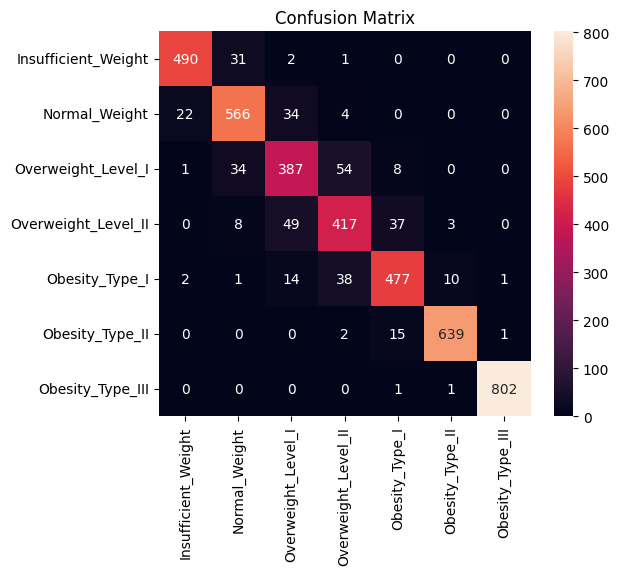

In [ ]:
mc = confusion_matrix(y_val, y_pred)
plt.figure(figsize = (6,5))
plt.title('Confusion Matrix')
sns.heatmap(pd.DataFrame(mc, index= ordinal_encoder.categories_[0],
                         columns = ordinal_encoder.categories_[0]), annot = True, fmt='d')
plt.show()

Từ Confusion Matrix, các prediction bị nhầm lẫn ở các class Overweight_Level_I và Overweight_Level_II

###  Use this when using voting. Use lgbm, xgb, gb as voting algorithm

Cải thiện accuracy bằng cách sử dụng VotingClassifier bao gồm 3 model LGBMClassifier, XGBCClasifier, GradientBoostingClassifier

In [ ]:
# sử dụng voting='soft'
clf_lgbm = LGBMClassifier(**best_params)
clf_xgb = XGBClassifier()
clf_gb = GradientBoostingClassifier()
voting_clf = VotingClassifier(estimators=[('lgbm', clf_lgbm), ('xgb',clf_xgb), ('gb',clf_gb )],
                              voting='soft')

print_result(voting_clf, X_train, X_val, y_train, y_val, selected_feat_chi2, selected_feat_rf)

VotingClassifier(estimators=[('lgbm',
                              LGBMClassifier(colsample_bytree=0.6282872225333296,
                                             lambda_l1=0.01224641358681502,
                                             lambda_l2=0.0367477631886496,
                                             learning_rate=0.012040133877842422,
                                             max_depth=11,
                                             metric='multi_logloss',
                                             min_child_samples=18,
                                             n_estimators=571, num_class=7,
                                             objective='multiclass',
                                             random_state=42,
                                             subsample=0.899604307323853,
                                             verbosity=-1)),...
                                            interaction_constraints=None,
                                  

(0.9058, 0.876, 0.9082)

In [ ]:
# sử dụng voting='hard'
clf_lgbm = LGBMClassifier(**best_params)
clf_xgb = XGBClassifier()
clf_gb = GradientBoostingClassifier()
voting_clf = VotingClassifier(estimators=[('lgbm', clf_lgbm), ('xgb',clf_xgb), ('gb',clf_gb )],
                              voting='hard')

print_result(voting_clf, X_train, X_val, y_train, y_val, selected_feat_chi2, selected_feat_rf)

VotingClassifier(estimators=[('lgbm',
                              LGBMClassifier(colsample_bytree=0.6282872225333296,
                                             lambda_l1=0.01224641358681502,
                                             lambda_l2=0.0367477631886496,
                                             learning_rate=0.012040133877842422,
                                             max_depth=11,
                                             metric='multi_logloss',
                                             min_child_samples=18,
                                             n_estimators=571, num_class=7,
                                             objective='multiclass',
                                             random_state=42,
                                             subsample=0.899604307323853,
                                             verbosity=-1)),...
                                            interaction_constraints=None,
                                  

(0.908, 0.8791, 0.9094)

VotingClassifier có accuracy thấp hơn LGBMClassifier

Tiếp tục improve model LGBMClassifier, tìm top 30 prediction sai nhất

In [ ]:
for i in range(7):
    # Lấy indices của mỗi lớp
    indices = y_val.reshape(-1,) == i
    # Tính accuracy cho lớp i
    class_accuracy = accuracy_score(y_val.reshape(-1,)[indices], y_pred[indices])
    print(f"Accuracy for Class {ordinal_encoder.categories_[0][i]}: {class_accuracy}")

Accuracy for Class Insufficient_Weight: 0.9351145038167938
Accuracy for Class Normal_Weight: 0.9041533546325878
Accuracy for Class Overweight_Level_I: 0.7995867768595041
Accuracy for Class Overweight_Level_II: 0.811284046692607
Accuracy for Class Obesity_Type_I: 0.8784530386740331
Accuracy for Class Obesity_Type_II: 0.9726027397260274
Accuracy for Class Obesity_Type_III: 0.9975124378109452


Class Overweight_Level_I và Overweight_Level_II có accuracy thấp nhất

In [ ]:
# tạo DataFrame thêm các cột
predict_proba=lgbm_classifier.predict_proba(X_val).max(axis=1)# lấy giá trị xác suất dự đoán lớn nhất

pred_df = pd.DataFrame({"y_true": y_val.reshape(-1),
                        "y_pred": y_pred,
                        "pred_conf": predict_proba,
                        "y_true_classname": [ordinal_encoder.categories_[0][int(i)] for i in y_val.reshape(-1)],
                        "y_pred_classname": [ordinal_encoder.categories_[0][int(i)] for i in y_pred]})

pred_df.head()

,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
0,6.0,6.0,0.999527,Obesity_Type_III,Obesity_Type_III
1,2.0,2.0,0.685623,Overweight_Level_I,Overweight_Level_I
2,4.0,4.0,0.935895,Obesity_Type_I,Obesity_Type_I
3,5.0,5.0,0.976229,Obesity_Type_II,Obesity_Type_II
4,0.0,1.0,0.531000,Insufficient_Weight,Normal_Weight


In [ ]:
# Thêm cột dự đoán True or False
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
0,6.0,6.0,0.999527,Obesity_Type_III,Obesity_Type_III,True
1,2.0,2.0,0.685623,Overweight_Level_I,Overweight_Level_I,True
2,4.0,4.0,0.935895,Obesity_Type_I,Obesity_Type_I,True
3,5.0,5.0,0.976229,Obesity_Type_II,Obesity_Type_II,True
4,0.0,1.0,0.531000,Insufficient_Weight,Normal_Weight,False


In [ ]:
pred_df.index=X_val.index # lấy index giống tập X_val

X = train.drop(['NObeyesdad'], axis=1)
X_train_2, X_val_2 = train_test_split(X, test_size=0.2, random_state=42)

In [ ]:
# gộp 2 df
df = pd.concat([X_val_2, pred_df], axis=1)
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,FAF,TUE,CALC,MTRANS,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
10317,Female,26.000000,1.649178,111.933010,yes,yes,3.000000,3.0,Sometimes,no,...,0.065264,0.711331,Sometimes,Public_Transportation,6.0,6.0,0.999527,Obesity_Type_III,Obesity_Type_III,True
4074,Male,18.000000,1.750000,80.000000,no,yes,2.000000,3.0,Sometimes,no,...,1.000000,1.000000,Sometimes,Public_Transportation,2.0,2.0,0.685623,Overweight_Level_I,Overweight_Level_I,True
9060,Female,23.360307,1.713380,84.722222,yes,yes,2.880161,3.0,Sometimes,no,...,2.000000,0.002600,no,Public_Transportation,4.0,4.0,0.935895,Obesity_Type_I,Obesity_Type_I,True
11286,Male,30.002029,1.670667,112.000381,yes,yes,1.572036,3.0,Sometimes,no,...,0.000000,0.114457,Sometimes,Public_Transportation,5.0,5.0,0.976229,Obesity_Type_II,Obesity_Type_II,True
8254,Male,17.000000,1.610000,50.000000,no,yes,2.000000,3.0,Sometimes,no,...,0.000000,2.000000,no,Public_Transportation,0.0,1.0,0.531000,Insufficient_Weight,Normal_Weight,False


In [ ]:
#  Lấy top 30 mẫu sai sai nhất
top_30 = df[df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:30]
top_30.head(10)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,FAF,TUE,CALC,MTRANS,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
16559,Female,25.994746,1.623707,105.036522,yes,yes,3.000000,3.000000,Sometimes,no,...,0.000000,0.453649,Sometimes,Public_Transportation,4.0,6.0,0.999536,Obesity_Type_I,Obesity_Type_III,False
3323,Male,17.491272,1.834637,59.990861,yes,yes,2.943749,4.000000,Sometimes,no,...,2.000000,0.128895,no,Automobile,2.0,0.0,0.997162,Overweight_Level_I,Insufficient_Weight,False
344,Male,37.936044,1.750150,118.668332,yes,yes,2.457548,3.000000,Sometimes,no,...,0.598655,0.000000,Sometimes,Automobile,4.0,5.0,0.993551,Obesity_Type_I,Obesity_Type_II,False
19611,Male,23.000000,1.650000,95.000000,yes,yes,2.000000,3.000000,Always,no,...,3.000000,2.000000,no,Public_Transportation,2.0,4.0,0.991107,Overweight_Level_I,Obesity_Type_I,False
4447,Male,29.000000,1.760000,112.000000,yes,yes,1.000000,3.000000,Always,no,...,0.000000,1.000000,Sometimes,Automobile,4.0,5.0,0.984589,Obesity_Type_I,Obesity_Type_II,False
17820,Male,24.000000,1.800000,65.000000,yes,yes,2.000000,3.000000,Frequently,no,...,1.000000,0.000000,no,Public_Transportation,0.0,1.0,0.984230,Insufficient_Weight,Normal_Weight,False
10479,Male,21.948577,1.849998,122.024954,yes,yes,3.000000,2.806298,Sometimes,no,...,0.065820,0.543118,Sometimes,Public_Transportation,6.0,5.0,0.984196,Obesity_Type_III,Obesity_Type_II,False
10880,Female,23.000000,1.660000,56.000000,yes,yes,2.000000,3.000000,Sometimes,no,...,2.000000,1.000000,Sometimes,Public_Transportation,0.0,1.0,0.976020,Insufficient_Weight,Normal_Weight,False
19055,Male,18.000000,1.780000,68.000000,yes,yes,2.000000,4.000000,Frequently,no,...,1.000000,1.000000,Frequently,Public_Transportation,2.0,1.0,0.974735,Overweight_Level_I,Normal_Weight,False
14801,Female,24.000000,1.570000,60.000000,yes,yes,2.000000,3.000000,Always,no,...,1.000000,0.000000,Sometimes,Public_Transportation,2.0,1.0,0.972842,Overweight_Level_I,Normal_Weight,False


In [ ]:
#pred_conf	y_true_classname	y_pred_classname
for i in top_30.columns:
  print(top_30[i].value_counts())

Female    15
Male      15
Name: Gender, dtype: int64
18.000000    5
23.000000    3
21.000000    3
17.000000    2
24.000000    2
38.397463    1
22.000000    1
21.082384    1
34.204408    1
37.642177    1
20.803186    1
25.994746    1
19.000000    1
17.491272    1
19.337404    1
41.000000    1
21.948577    1
29.000000    1
37.936044    1
20.908785    1
Name: Age, dtype: int64
1.660000    2
1.780000    2
1.560000    2
1.623707    1
1.710000    1
1.660324    1
1.690000    1
1.720000    1
1.717775    1
1.679299    1
1.675953    1
1.500000    1
1.561109    1
1.529834    1
1.557808    1
1.657310    1
1.620000    1
1.834637    1
1.588147    1
1.816298    1
1.570000    1
1.849998    1
1.800000    1
1.760000    1
1.650000    1
1.750150    1
1.750000    1
Name: Height, dtype: int64
60.000000     2
105.036522    1
53.000000     1
104.790549    1
80.000000     1
52.000000     1
80.993373     1
77.205685     1
79.544998     1
62.000000     1
77.550345     1
40.202773     1
64.000000     1
79.437921 

In [ ]:
top_30[top_30['y_true']==2]

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,FAF,TUE,CALC,MTRANS,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
3323,Male,17.491272,1.834637,59.990861,yes,yes,2.943749,4.000000,Sometimes,no,...,2.000000,0.128895,no,Automobile,2.0,0.0,0.997162,Overweight_Level_I,Insufficient_Weight,False
19611,Male,23.000000,1.650000,95.000000,yes,yes,2.000000,3.000000,Always,no,...,3.000000,2.000000,no,Public_Transportation,2.0,4.0,0.991107,Overweight_Level_I,Obesity_Type_I,False
19055,Male,18.000000,1.780000,68.000000,yes,yes,2.000000,4.000000,Frequently,no,...,1.000000,1.000000,Frequently,Public_Transportation,2.0,1.0,0.974735,Overweight_Level_I,Normal_Weight,False
14801,Female,24.000000,1.570000,60.000000,yes,yes,2.000000,3.000000,Always,no,...,1.000000,0.000000,Sometimes,Public_Transportation,2.0,1.0,0.972842,Overweight_Level_I,Normal_Weight,False
8746,Female,18.000000,1.588147,68.392133,yes,no,2.000000,1.313403,Sometimes,no,...,1.932386,1.094941,no,Public_Transportation,2.0,3.0,0.965359,Overweight_Level_I,Overweight_Level_II,False
1429,Female,19.000000,1.620000,53.000000,yes,yes,3.000000,3.000000,Sometimes,no,...,2.000000,1.000000,no,Public_Transportation,2.0,1.0,0.964052,Overweight_Level_I,Normal_Weight,False
980,Female,21.000000,1.560000,60.000000,yes,yes,2.000000,3.000000,Sometimes,no,...,0.000000,1.000000,Sometimes,Public_Transportation,2.0,1.0,0.958632,Overweight_Level_I,Normal_Weight,False
15303,Female,21.000000,1.500000,62.000000,yes,no,3.000000,1.000000,Sometimes,no,...,0.000000,0.000000,no,Public_Transportation,2.0,3.0,0.952975,Overweight_Level_I,Overweight_Level_II,False
12134,Female,18.000000,1.675953,79.544998,yes,no,2.000000,2.271734,Sometimes,no,...,0.390877,1.440629,Frequently,Public_Transportation,2.0,3.0,0.952205,Overweight_Level_I,Overweight_Level_II,False
5754,Female,34.204408,1.679299,77.205685,yes,yes,2.186322,1.672706,Sometimes,no,...,2.119682,0.696948,no,Automobile,2.0,3.0,0.943222,Overweight_Level_I,Overweight_Level_II,False


In [ ]:
top_30[top_30['y_true']==3]

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,FAF,TUE,CALC,MTRANS,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
10202,Female,41.000000,1.560000,80.400306,yes,yes,2.000000,3.000000,Sometimes,no,...,0.0,0.000000,Sometimes,Automobile,3.0,4.0,0.972489,Overweight_Level_II,Obesity_Type_I,False
9198,Male,19.337404,1.816298,87.803311,no,yes,2.443674,3.000000,Sometimes,no,...,2.0,0.993786,Sometimes,Public_Transportation,3.0,2.0,0.970520,Overweight_Level_II,Overweight_Level_I,False
15542,Female,38.397463,1.557808,79.437921,yes,yes,1.317729,1.231915,Sometimes,no,...,0.0,0.000000,no,Automobile,3.0,4.0,0.960558,Overweight_Level_II,Obesity_Type_I,False
18842,Female,37.642177,1.561109,77.550345,yes,yes,2.000000,3.000000,Sometimes,no,...,0.0,0.000000,no,Automobile,3.0,4.0,0.953588,Overweight_Level_II,Obesity_Type_I,False


In [ ]:
X_train.columns

Index(['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE',
       'Gender_Male', 'family_history_with_overweight_yes', 'FAVC_yes',
       'CAEC_Frequently', 'CAEC_Sometimes', 'CAEC_no', 'SMOKE_yes', 'SCC_yes',
       'CALC_Sometimes', 'CALC_no', 'MTRANS_Bike', 'MTRANS_Motorbike',
       'MTRANS_Public_Transportation', 'MTRANS_Walking'],
      dtype='object')

Dựa vào top 30 các lỗi sai nhất, ta loại bỏ các feature có các label không đổi

In [ ]:
feature_top30 = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE',
                 'Gender_Male', 'CALC_Sometimes','CALC_no','CAEC_Frequently','CAEC_Sometimes',
                 'CAEC_no','MTRANS_Bike','MTRANS_Motorbike', 'MTRANS_Public_Transportation',
                 'MTRANS_Walking']

lgbm_classifier = LGBMClassifier(**best_params)

lgbm_classifier.fit(X_train[feature_top30], y_train)
y_pred = lgbm_classifier.predict(X_val[feature_top30])
accuracy_score(y_val, y_pred)

0.905587668593449

accuracy không được cải thiện, confusion matrix xem class 2 và 3 có cải thiện không

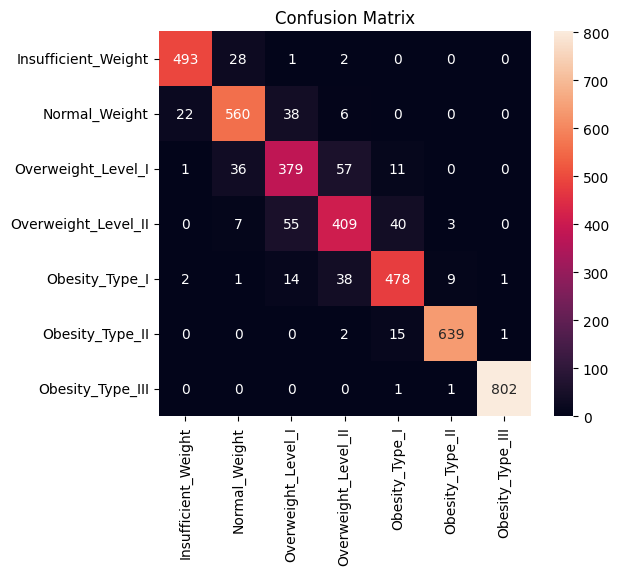

In [ ]:
mc = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6,5))
plt.title('Confusion Matrix')
sns.heatmap(pd.DataFrame(mc, index= ordinal_encoder.categories_[0],
                         columns = ordinal_encoder.categories_[0]), annot=True, fmt='d')
plt.show()

Class Overweight_Level_I và Overweight_Level_II vẫn không được cải thiện

Tạo 1 model con chuyên phân loại 2 class Overweight_Level_I và Overweight_Level_II. Chọn 1 số feature có phân phối khác biệt ở 2 class Overweight_Level_I và Overweight_Level_II

In [ ]:
select_feature = ['Age', 'Height', 'Weight',
                  'family_history_with_overweight_yes','SCC_yes',
                  'CALC_Sometimes', 'CALC_no']

lgbm_classifier = LGBMClassifier(**best_params)

lgbm_classifier.fit(X_train[select_feature], y_train)

y_pred = lgbm_classifier.predict(X_val[select_feature])
accuracy_score(y_val, y_pred)

0.8899325626204239

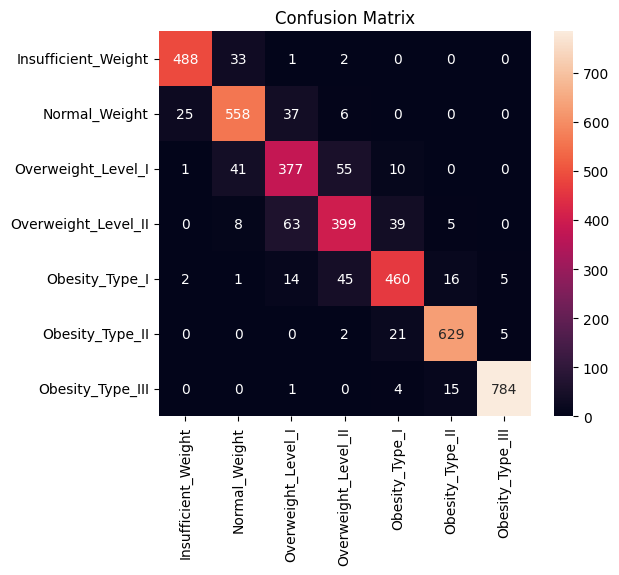

In [ ]:
mc = confusion_matrix(y_val, y_pred)
plt.figure(figsize = (6,5))
plt.title('Confusion Matrix')
sns.heatmap(pd.DataFrame(mc, index= ordinal_encoder.categories_[0],
                         columns = ordinal_encoder.categories_[0]), annot = True, fmt='d')
plt.show()

Nhầm lẫn giữa 2 class Overweight_Level_I và Overweight_Level_II vẫn không được improve

## 4.3 Prediction on Test data

Đưa ra prediction trên test data bằng  LGBMClassifier

In [ ]:

lgbm_classifier = LGBMClassifier(**best_params)
lgbm_classifier.fit(X_train, y_train)
predictions = lgbm_classifier.predict(X_test)

pred = ordinal_encoder.inverse_transform(predictions.reshape(-1,1))

submission = pd.read_csv("/content/drive/MyDrive/project_MLP305/sample_submission.csv")
submission["NObeyesdad"] = pred
submission.to_csv("/content/drive/MyDrive/project_MLP305/submission.csv", index=False)
submission.head()

,id,NObeyesdad
0,20758,Obesity_Type_II
1,20759,Overweight_Level_I
2,20760,Obesity_Type_III
3,20761,Obesity_Type_I
4,20762,Obesity_Type_III


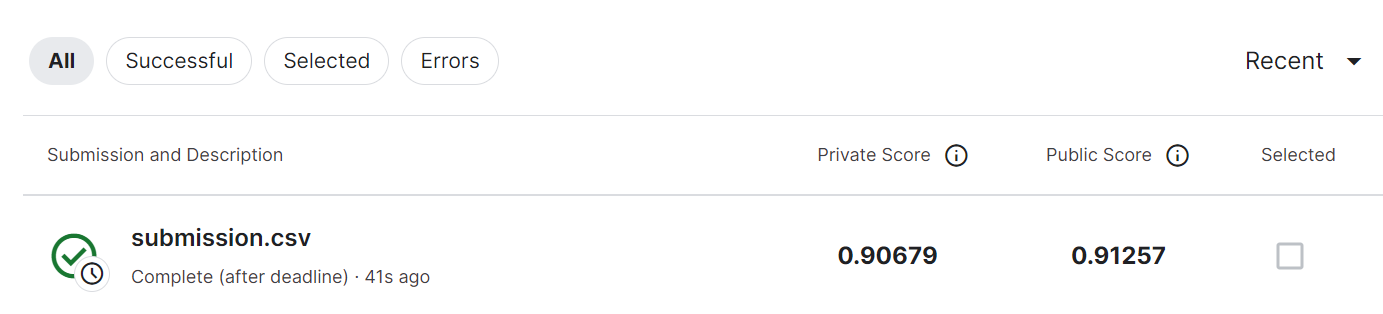

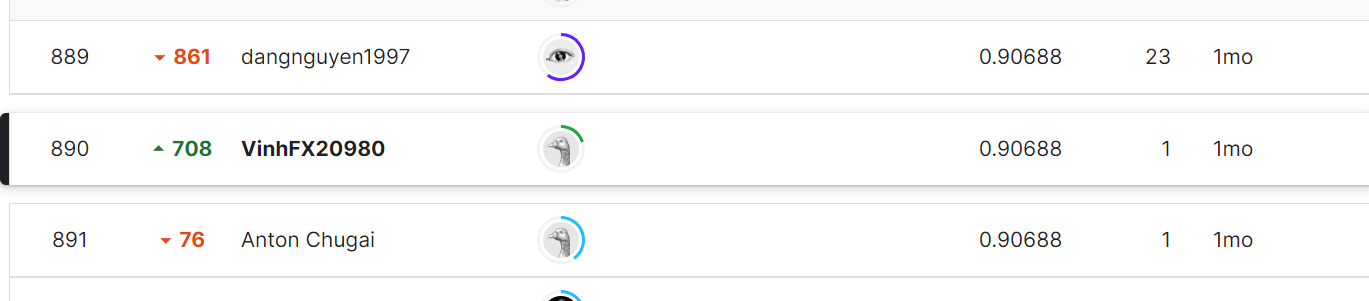

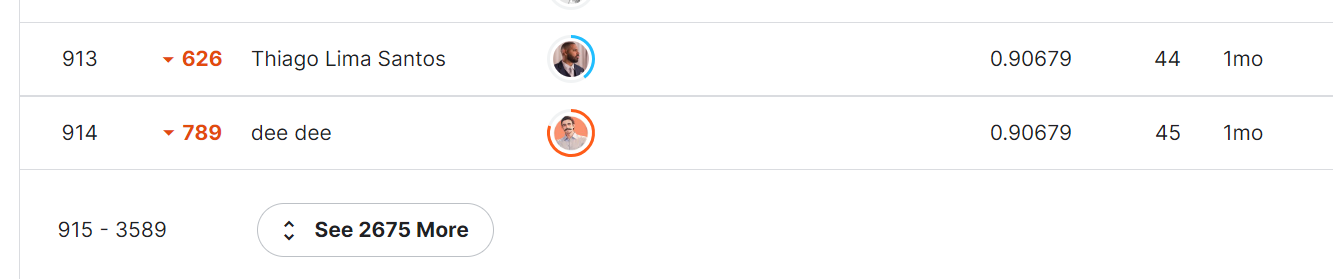

In [ ]:
from IPython.display import Image, display

image_path = ['/content/drive/MyDrive/project_MLP305/submiss.PNG',
              '/content/drive/MyDrive/project_MLP305/rank_708.PNG',
              '/content/drive/MyDrive/project_MLP305/number_rank.PNG']

for path in image_path:
    display(Image(filename=path))

Sau khi submission được hạng 708 nămg trong top 20% có accuracy cao nhất

# 5. Conclusion

Logistic Regression: model này đạt được độ chính xác ở mức khá

Decision Trees: Decision Trees cho thấy hiệu suất thấp hơn một chút so với Logistic Regression. Tuy nhiên, accuracy vẫn cao, cho thấy hiệu quả phân loại theo mô hình.

Random Forest hoạt động tốt hơn Decision Trees

AdaBoostClassifier cho ra kết quả tệ

SVC cho kết quả khá

Các model LGBMClassifier, GradientBoostingClassifie, XGBClassifier cho kết quả tương đối tốt, nhưng LGBMClassifier cho kết quả tốt nhất nên ta improve model này

Việc hyperparameter tuning đã mang lại sự cải thiện đáng kể về hiệu suất của model, bằng chứng là accuracy đã tăng lên. Tuy nhiên vẫn chưa cải thiện được các class cho prediction sai nhất

# Demo model

In [ ]:
# import data
demo = pd.read_csv('/content/drive/MyDrive/project_MLP305/demo.csv')

X_train, X_val,y_train, y_val, demo = pre_stand(X,y,demo,continuous_vars) # chuẩn hoá dữ liệu

# đưa ra prediction
pred_demo = lgbm_classifier.predict(demo)
pred = ordinal_encoder.inverse_transform(pred_demo.reshape(-1,1))
pred

array([['Obesity_Type_II'],
       ['Overweight_Level_I']], dtype=object)